# Simulations and analysis of RDAM model

This notebook contains simulations and analysis of the following equations:

$$c_t = \frac{1}{Da} c_{xx} - ( v c)_{x} + f(c)$$
$$v_{xx} + \Omega(c) c_x =  v  $$

used in the paper "Front speed and pattern selection of a propagating chemical front in an active fluid" by Clara del Junco, André Estevez-Torres, and Ananyo Maitra.

Note: xmax in this code corresponds to L in the paper; tmax corresponds to T

===============Load packages===============

Note: you will need to install the active_rd_simulation code by navigating into the folder active_rd_simulation and running ```pip install -e .``` The ```-e``` makes sure any edits that you make to the code are updated in the appropriate place in your Python library.

In [37]:
#custom code for these simulations.
from active_rd_simulation import Repeat_Simulation, Unique_Simulation, plot_snapshots, get_front_speed
#plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from scipy.optimize import curve_fit
import matplotlib.cm as cm
#signal processing
from scipy import signal
from numpy.fft import fft
#general
import numpy as np
import pickle
import os

#fxn to play a sound when finished executing - put at the end of a cell that takes longer to execute
from IPython.display import Audio, display
def allDone():
    display(Audio(url='belltone.wav', autoplay=True))

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [38]:
#change matplotlib default font and font size
from matplotlib import rcParams
rcParams['mathtext.default']='regular'
rcParams['font.size'] = 16

===============Define functions===============

In [39]:
def line(x, m, b):
    return m * x + b

In [40]:
#linear stability analysis predictions

RXN_DICT = {'quad':1, 'cube':2}
STRESS_DICT = {'lin':1, 'c2':2, 'sat':1./4}

def sigma(Da, Omega, q, rxn = 'quad', stress = 'lin'):  
    """
    growth rate of perturbation of wavenumber q from lsa, assuming \delta c ~ \exp(iqx + \sigma t)
    """
    return -np.power(q, 2)*(1/Da - STRESS_DICT[stress]*Omega/(1 + np.power(q, 2)) + RXN_DICT[rxn]*np.power(q, -2))

def omega_crit_q(Da, q, rxn = 'quad', stress = 'lin'):
    """
    value of omega where sigma = 0, at a given q
    """
    return (1 + np.power(q, 2))*(RXN_DICT[rxn] * Da + np.power(q, 2))/(Da * np.power(q, 2) * STRESS_DICT[stress])

def omega_crit_inf(Da, rxn = 'quad', stress = 'lin'):
    """
    value of omega where sigma is first equal to 0, in the limit of infinite system size
    """
    return (Da*RXN_DICT[rxn] + 2*np.sqrt(Da * RXN_DICT[rxn]) + 1)/(STRESS_DICT[stress]*Da)

def q_max_lsa(Omega, Da, stress = 'lin'):
    """
    value of q at the maximum of sigma(Da, \Omega, q)
    """
    return np.sqrt(-1 + np.sqrt(Da * STRESS_DICT[stress] * Omega))  

def q_discrete(xmax, n):
    """
    nth allowed wavenumber q in a box of size xmax (with PBC)
    """
    return 2*np.pi*n/xmax

def qmax_discrete(Omega, Da, xmax, rxn = 'quad', stress = 'lin'):
    """
    value of q where sigma(q) is maximized for a given Omega, Da, and box size 
    """
    sigma_values = np.array([sigma(Da, Omega, q_discrete(xmax, n), rxn=rxn, stress=stress) for n in range(1, 500)])
    nmax = 1 + np.argmax(sigma_values)
    return(q_discrete(xmax, nmax))

# Figures 2 & 6: Simulation examples

In [5]:
#print out critical value of \Omega in an infinite system 
#for different stress and reaction term combinations
for stress in ['lin', 'c2', 'sat']:
    for rxn in ['quad', 'cube']:
        print(stress + ', ' + rxn + ', '+ '{:3f}'.format(omega_crit_inf(0.4, rxn = rxn, stress = stress)))

lin, quad, 6.662278
lin, cube, 8.972136
c2, quad, 3.331139
c2, cube, 4.486068
sat, quad, 26.649111
sat, cube, 35.888544


===========stress : $\zeta(c) \propto c$=============

===========reaction: $f(c) \propto c(1-c)$============

file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


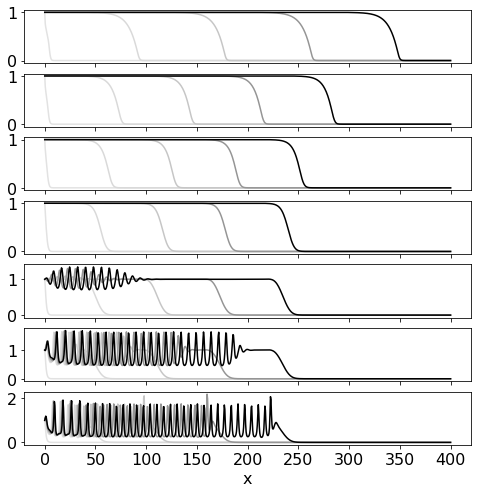

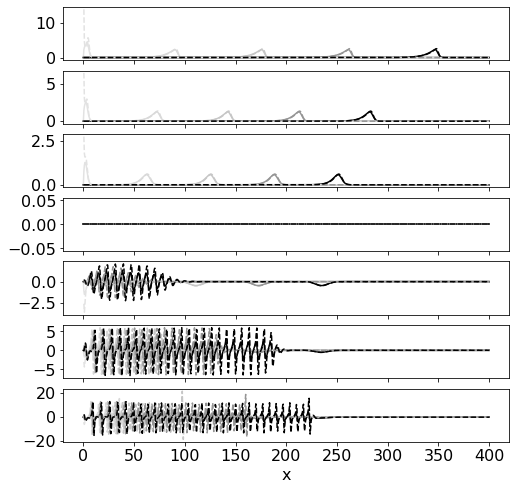

In [6]:
#physical parameters
Omega_list = [-30, -15, -7, 0, 7, 8, 10]
Da = 0.4

#linear stress: $\zeta(c) = \alpha c$
stress = 'lin'
#step function initial conditions
init = 'step'
#fixed boundary conditions: c(0) = 1, c(xmax) = 0
bc = 'fixed'

#simulation parameters
dx = 0.05
dt = 0.1
xmax = 400
tmax = 100
x_save_interval = 10
t_save_interval = 1

fig, ax = plt.subplots(len(Omega_list), 1, sharex = True)
fig2, ax2 = plt.subplots(len(Omega_list), 1, sharex = True)

for i, Omega in enumerate(Omega_list):
    my_sim = Unique_Simulation(Da, Omega, stress, init, bc, dt, tmax, t_save_interval, dx, xmax, x_save_interval)
    plot_snapshots(my_sim, 5, var = 'c', ax = ax[i])
    plot_snapshots(my_sim, 5, var = 'v', ax = ax2[i])
    plot_snapshots(my_sim, 5, var = 'cgrad', ax = ax2[i])
    
fig.set_size_inches(8, 8)
ax[-1].set_xlabel("x")
fig2.set_size_inches(8, 8)
# fig.set_tight_layout(True)
fig.savefig('Plots/sim-ex-stress{:}.pdf'.format(stress))

===============Make a movie of the trajectory at $\Omega = 7$================

In [7]:
#create writer
import matplotlib.animation as animation
Writer = animation.writers['ffmpeg']
writer = Writer(fps = 80, metadata = dict(artist='Me'), bitrate = -1)

file found, loading...


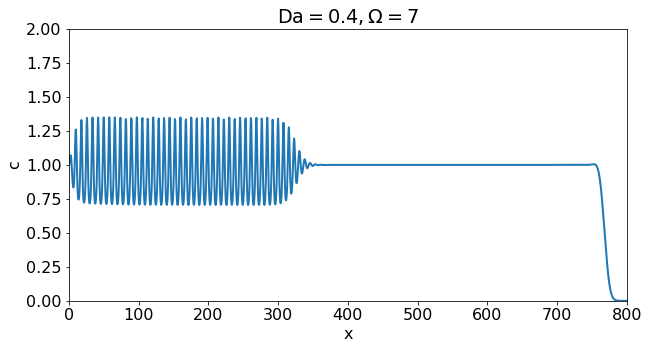

In [8]:
#load trajectory

Omega = 7
Da = 0.4
stress = 'lin'
init = 'step'
bc = 'fixed'
dx = 0.05
dt = 0.1
xmax = 800
tmax = 250
x_save_interval = 10
t_save_interval = 1

my_sim = Unique_Simulation(Da, Omega, stress, init, bc, dt, tmax, t_save_interval, dx, xmax, x_save_interval)

#set up plot
fig = plt.figure(figsize = (10, 5))
ax = plt.axes(xlim = (0, 800), ylim = (0, 2))
line2, = ax.plot([], [], lw = 2)

def init():
    line2.set_data([], [])
    return line2,

def animate(i):
    line2.set_data(my_sim.x, my_sim.sol_c[i])
    return line2,

ax.set_xlabel("x")
ax.set_ylabel("c")
plt.title(r"$Da = 0.4, \Omega = 7$")

#make movie
ani = animation.FuncAnimation(fig, animate, init_func = init, frames = 2499, blit = False)

ani.save('Plots/omega-7-movie.mp4', writer = writer, dpi = 300)

===========stress : $\zeta(c) \propto c^2$=============

===========reaction: $f(c) \propto c(1-c)$============

file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


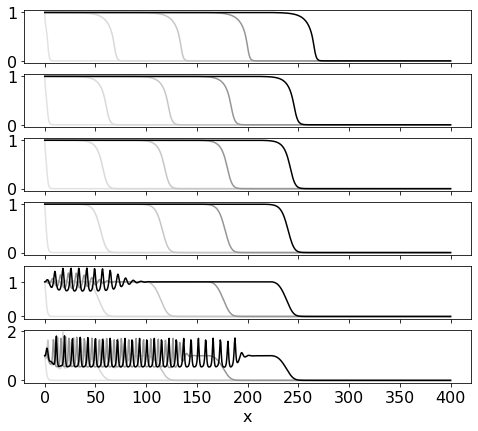

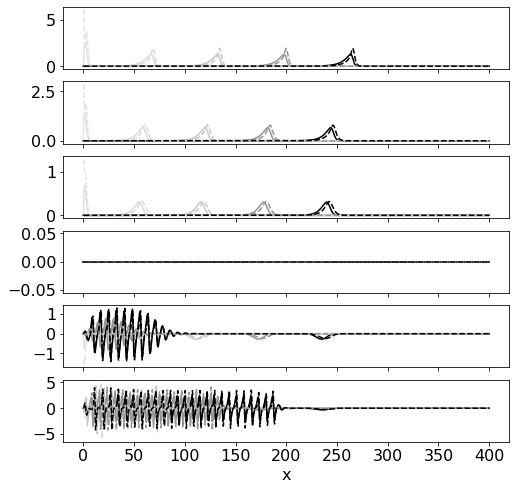

In [9]:
#physical parameters
Omega_list = 0.5*np.array([-30, -15, -7, 0, 7, 8])
Da = 0.4

#quadratic stress: $\zeta(c) = \alpha c^2$
stress = 'c2'
#step function initial conditions
init = 'step'
#fixed boundary conditions: c(0) = 1, c(xmax) = 0
bc = 'fixed'

#simulation parameters
dx = 0.05
dt = 0.1
xmax = 400
tmax = 100
x_save_interval = 10
t_save_interval = 1

fig, ax = plt.subplots(len(Omega_list), 1, sharex = True)
fig2, ax2 = plt.subplots(len(Omega_list), 1, sharex = True)

for i, Omega in enumerate(Omega_list):
    my_sim = Unique_Simulation(Da, Omega, stress, init, bc, dt, tmax, t_save_interval, dx, xmax, x_save_interval)
    plot_snapshots(my_sim, 5, var = 'c', ax = ax[i])
    plot_snapshots(my_sim, 5, var = 'v', ax = ax2[i])
    plot_snapshots(my_sim, 5, var = 'cgrad', ax = ax2[i])
    
fig.set_size_inches(8, 8*6/7)
ax[-1].set_xlabel("x")
fig2.set_size_inches(8, 8)
fig.savefig('Plots/sim-ex-stress{:}.pdf'.format(stress))

===========stress : $\zeta(c) \propto c/(1+c)$=============

===========reaction: $f(c) \propto c(1-c)$============

file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


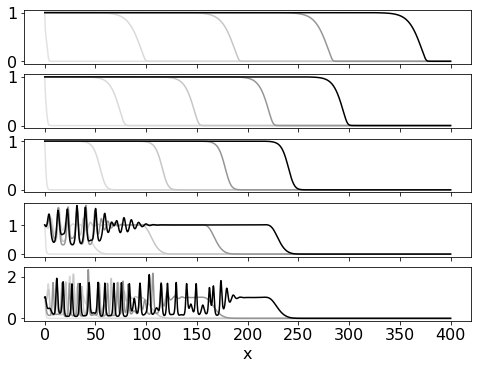

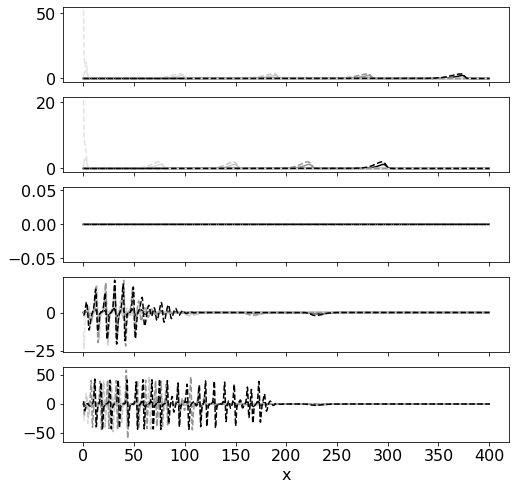

In [10]:
#physical parameters
Omega_list = 4*np.array([-15, -7, 0, 7, 8])
Da = 0.4

#saturating stress: $\zeta(c) = \alpha c/(1 + c)$
stress = 'sat'
#step function initial conditions
init = 'step'
#fixed boundary conditions: c(0) = 1, c(xmax) = 0
bc = 'fixed'

#simulation parameters
dx = 0.01
dt = 0.05
xmax = 400
tmax = 100
x_save_interval = 20
t_save_interval = 1

fig, ax = plt.subplots(len(Omega_list), 1, sharex = True)
fig2, ax2 = plt.subplots(len(Omega_list), 1, sharex = True)

for i, Omega in enumerate(Omega_list):
    my_sim = Unique_Simulation(Da, Omega, stress, init, bc, dt, tmax, t_save_interval, dx, xmax, x_save_interval)
    plot_snapshots(my_sim, 5, var = 'c', ax = ax[i])
    plot_snapshots(my_sim, 5, var = 'v', ax = ax2[i])
    plot_snapshots(my_sim, 5, var = 'cgrad', ax = ax2[i])
    
fig.set_size_inches(8, 8*5/7)
ax[-1].set_xlabel("x")
fig2.set_size_inches(8, 8)
fig.savefig('Plots/sim-ex-stress{:}.pdf'.format(stress))

===========stress : $\zeta(c) \propto c$=============

===========reaction: $f(c) \propto c(1-c^2)$============

file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


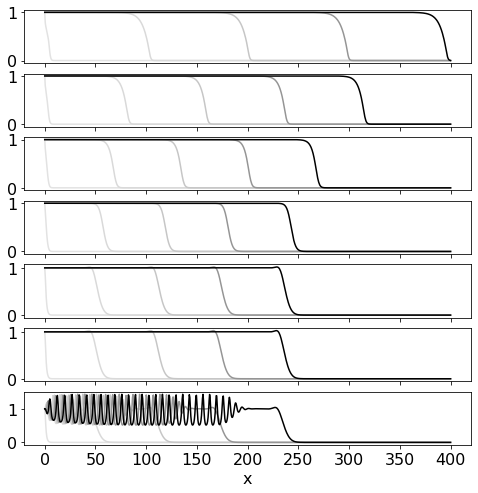

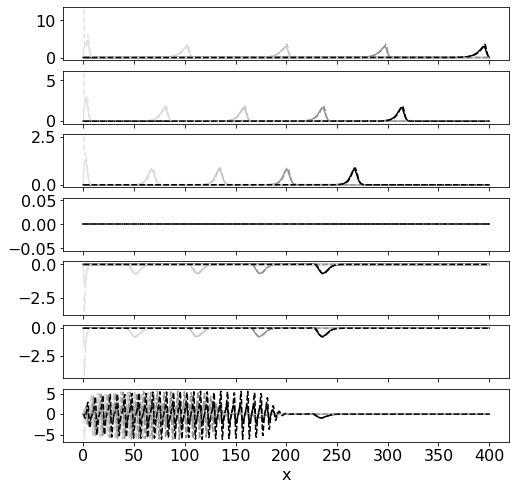

In [11]:
#physical parameters
Omega_list = np.array([-30, -15, -7, 0, 7, 8, 10])
Da = 0.4

#linear stress: $\zeta(c) = \alpha c$
stress = 'lin'
#step function initial conditions
init = 'step'
#fixed boundary conditions: c(0) = 1, c(xmax) = 0
bc = 'fixed'
#cubic reaction term c(1-c^2)
rxn = 'cube'

#simulation parameters
dx = 0.05
dt = 0.1
xmax = 400
tmax = 100
x_save_interval = 10
t_save_interval = 1

fig, ax = plt.subplots(len(Omega_list), 1, sharex = True)
fig2, ax2 = plt.subplots(len(Omega_list), 1, sharex = True)

for i, Omega in enumerate(Omega_list):
    my_sim = Unique_Simulation(Da, Omega, stress, init, bc, dt, tmax, t_save_interval, dx, xmax, x_save_interval, rxn = rxn)
    plot_snapshots(my_sim, 5, var = 'c', ax = ax[i])
    plot_snapshots(my_sim, 5, var = 'v', ax = ax2[i])
    plot_snapshots(my_sim, 5, var = 'cgrad', ax = ax2[i])
    
fig.set_size_inches(8, 8)
ax[-1].set_xlabel("x")
fig2.set_size_inches(8, 8)
fig.savefig('Plots/sim-ex-stress{:}-rxn{:}.pdf'.format(stress, rxn))

===========stress : $\zeta(c) \propto c/(1+c)$=============

===========reaction: $f(c) \propto c(1-c^2)$============

file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


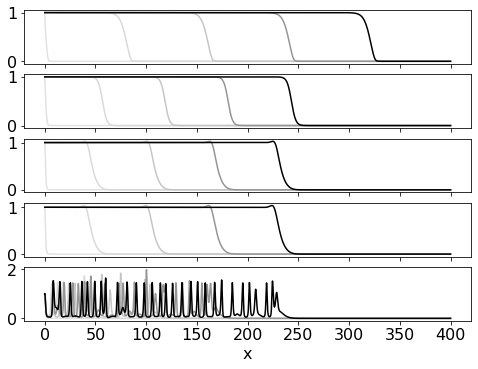

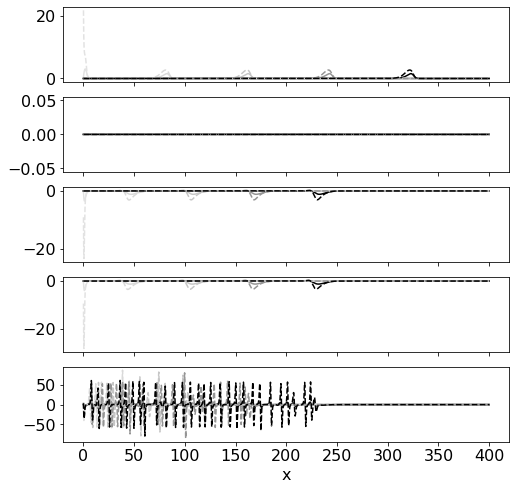

In [12]:
#physical parameters
Omega_list = 4*np.array([-7, 0, 7, 8, 10])
Da = 0.4

#saturating stress: $\zeta(c) = \alpha c/(1 + c)$
stress = 'sat'
#step function initial conditions
init = 'step'
#fixed boundary conditions: c(0) = 1, c(xmax) = 0
bc = 'fixed'
#cubic reaction term c(1-c^2)
rxn = 'cube'

#simulation parameters
dx = 0.01
dt = 0.05
xmax = 400
tmax = 100
x_save_interval = 10
t_save_interval = 1

fig, ax = plt.subplots(len(Omega_list), 1, sharex = True)
fig2, ax2 = plt.subplots(len(Omega_list), 1, sharex = True)

for i, Omega in enumerate(Omega_list):
    my_sim = Unique_Simulation(Da, Omega, stress, init, bc, dt, tmax, t_save_interval, dx, xmax, x_save_interval, rxn = rxn)
    plot_snapshots(my_sim, 5, var = 'c', ax = ax[i])
    plot_snapshots(my_sim, 5, var = 'v', ax = ax2[i])
    plot_snapshots(my_sim, 5, var = 'cgrad', ax = ax2[i])
    
fig.set_size_inches(8, 8*5/7)
ax[-1].set_xlabel("x")
fig2.set_size_inches(8, 8)
fig.savefig('Plots/sim-ex-stress{:}-rxn{:}.pdf'.format(stress, rxn))

===========stress : $\zeta(c) \propto c^2$=============

===========reaction: $f(c) \propto c(1-c^2)$============

file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


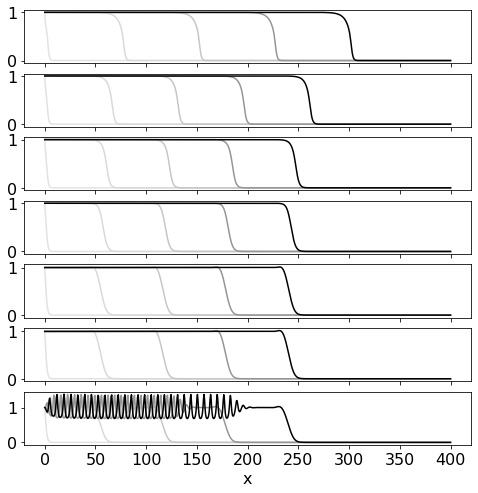

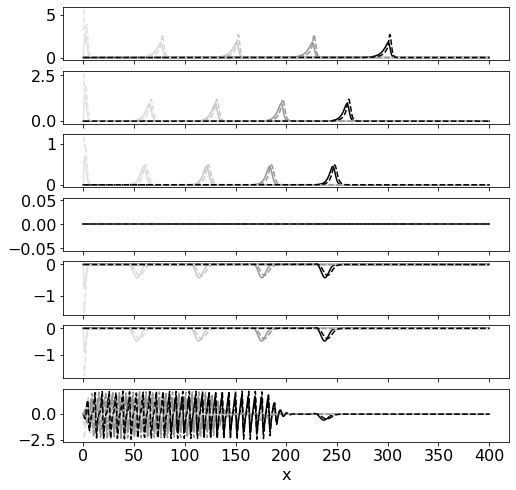

In [13]:
#physical parameters
Omega_list = 0.5*np.array([-30, -15, -7, 0, 7, 8, 10])
Da = 0.4

#quadratic stress: $\zeta(c) = \alpha c^2$
stress = 'c2'
#step function initial conditions
init = 'step'
#fixed boundary conditions: c(0) = 1, c(xmax) = 0
bc = 'fixed'
#cubic reaction term c(1-c^2)
rxn = 'cube'

#simulation parameters
dx = 0.05
dt = 0.1
xmax = 400
tmax = 100
x_save_interval = 10
t_save_interval = 1

fig, ax = plt.subplots(len(Omega_list), 1, sharex = True)
fig2, ax2 = plt.subplots(len(Omega_list), 1, sharex = True)

for i, Omega in enumerate(Omega_list):
    my_sim = Unique_Simulation(Da, Omega, stress, init, bc, dt, tmax, t_save_interval, dx, xmax, x_save_interval, rxn = rxn)
    plot_snapshots(my_sim, 5, var = 'c', ax = ax[i])
    plot_snapshots(my_sim, 5, var = 'v', ax = ax2[i])
    plot_snapshots(my_sim, 5, var = 'cgrad', ax = ax2[i])
    
fig.set_size_inches(8, 8)
ax[-1].set_xlabel("x")
fig2.set_size_inches(8, 8)
fig.savefig('Plots/sim-ex-stress{:}-rxn{:}.pdf'.format(stress, rxn))

# Figs  3 & 4: Front speed

#### 0. Check effect of box size, total time, dx, dt

Find simulation parameters that allow us to recover the known case, $k = 2/\sqrt{Da}$, when $\Omega = 0$ and that we are in a regime where changing the parameters does not affect the results.

===============Varying the box length (xmax)=====================

file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


Text(0, 0.5, 'front speed')

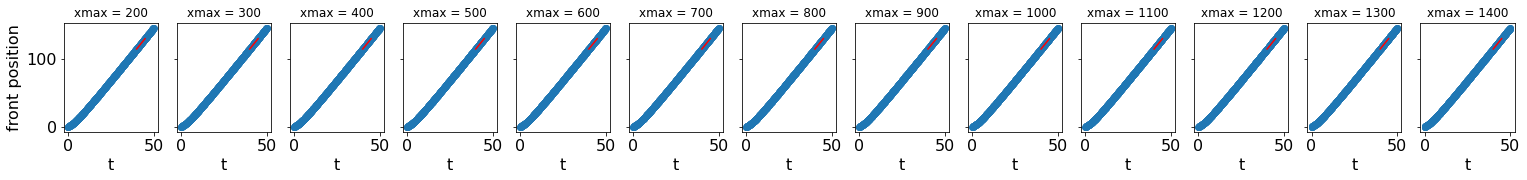

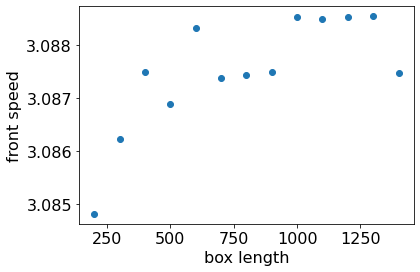

In [14]:
Da = 0.4
Omega = 0

stress = "lin"
init = "step"
bc = "fixed"

dx = 0.1
dt = 0.1
xmax_list = np.arange(200, 1500, 100)
tmax = 50 
x_save_interval = 1
t_save_interval = 1

front_speed = []

fig, ax = plt.subplots(1, len(xmax_list), sharey = True, figsize = (2*len(xmax_list), 2))

for i, xmax in enumerate(xmax_list):
    my_sim = Unique_Simulation(Da, Omega, stress, init, bc, dt, tmax, t_save_interval, dx, xmax, x_save_interval)
    front_speed.append(get_front_speed(my_sim, plot = True, ax = ax[i]))
    ax[i].set_xlabel("t")
    ax[i].set_title("xmax = {:}".format(xmax), fontsize = 12)

ax[0].set_ylabel("front position")
    
plt.figure()
plt.scatter(xmax_list, front_speed)
plt.xlabel("box length")
plt.ylabel("front speed")

================Varying the simulation time (tmax)=====================

Starting from a step function (front has to accelerate to reach selected speed)

file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


Text(0, 0.5, 'front speed')

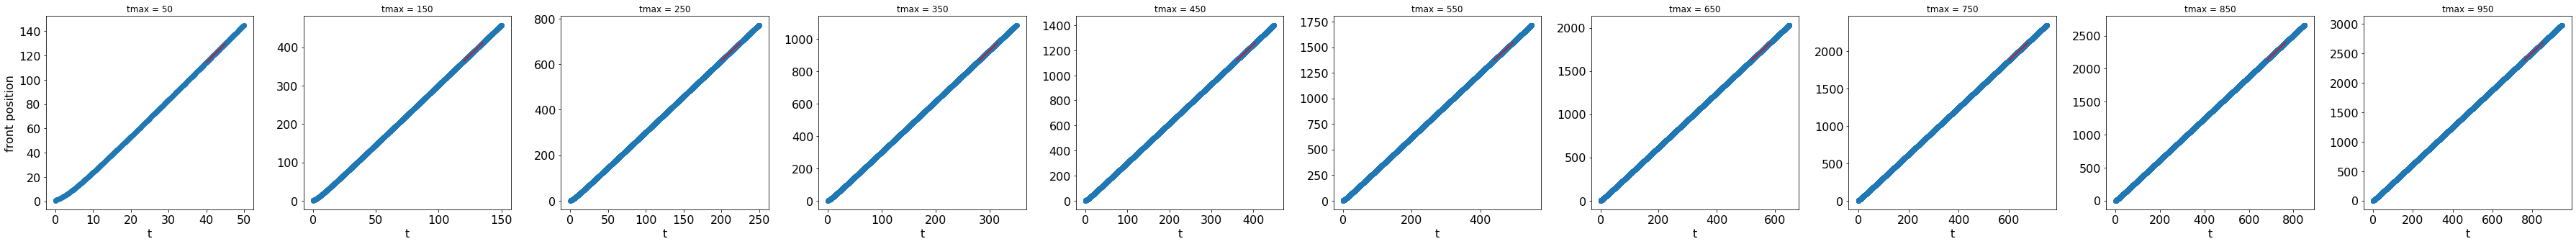

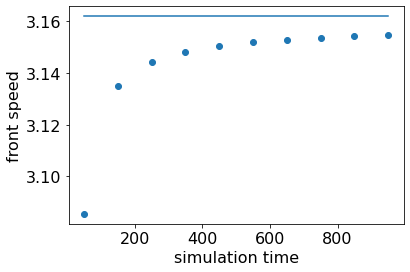

In [15]:
Da = 0.4
Omega = 0


stress = "lin"
init = "step"
bc = "fixed"

dx = 0.1
dt = 0.1
xmax = 3000
tmax_list = np.arange(50, 1000, 100) 
x_save_interval = 1
t_save_interval = 1

front_speed = []

fig, ax = plt.subplots(1, len(tmax_list), figsize = (5*len(tmax_list), 5))

for i, tmax in enumerate(tmax_list):
    my_sim = Unique_Simulation(Da, Omega, stress, init, bc, dt, tmax, t_save_interval, dx, xmax, x_save_interval)
    front_speed.append(get_front_speed(my_sim, plot = True, ax = ax[i]))
    ax[i].set_xlabel("t")
    ax[i].set_title("tmax = {:}".format(tmax), fontsize = 12)

ax[0].set_ylabel("front position")
plt.tight_layout()

plt.figure()
plt.scatter(tmax_list, front_speed)
#plot known value
plt.plot(tmax_list, np.full(len(tmax_list), 3.162))
plt.xlabel("simulation time")
plt.ylabel("front speed")

Above tmax $\approx$ 800, the front speed stops changing.

=====================Starting from a shallow tanh function (front has to decelerate to reach selected speed)=====================

file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


Text(0, 0.5, 'front speed')

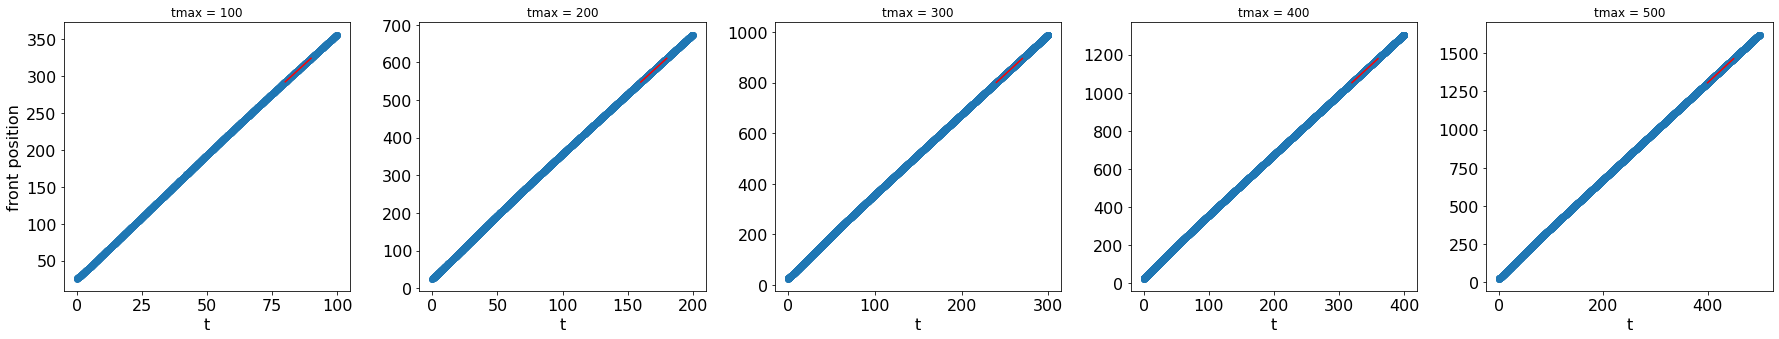

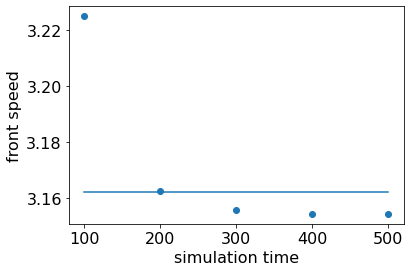

In [16]:
Da = 0.4
Omega = 0


stress = "lin"
init = "tanh"
slope = 5
bc = "fixed"

dx = 0.1
dt = 0.1
xmax_list = np.full(len(np.arange(100, 350, 100)), 1000).tolist() + [1500, 1750]
tmax_list = np.arange(100, 350, 100).tolist() + [400, 500]
x_save_interval = 1
t_save_interval = 1

front_speed_5 = []

fig, ax = plt.subplots(1, len(tmax_list), figsize = (5*len(tmax_list), 5))

for i, (tmax, xmax) in enumerate(zip(tmax_list, xmax_list)):
    my_sim = Unique_Simulation(Da, Omega, stress, init, bc, dt, tmax, t_save_interval, dx, xmax, x_save_interval, slope = slope)
    front_speed_5.append(get_front_speed(my_sim, plot = True, ax = ax[i]))
    ax[i].set_xlabel("t")
    ax[i].set_title("tmax = {:}".format(tmax), fontsize = 12)

ax[0].set_ylabel("front position")
plt.tight_layout()
    
plt.figure()
plt.scatter(tmax_list, front_speed_5)
#plot known value
plt.plot(tmax_list, np.full(len(tmax_list), 3.162))
plt.xlabel("simulation time")
plt.ylabel("front speed")

=====================Varying grid size (dx)=====================

file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


Text(0, 0.5, 'front speed')

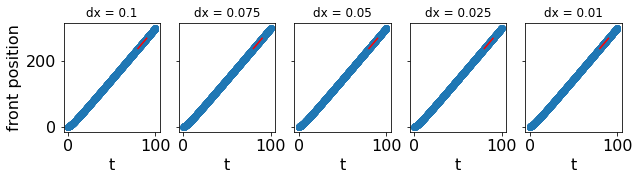

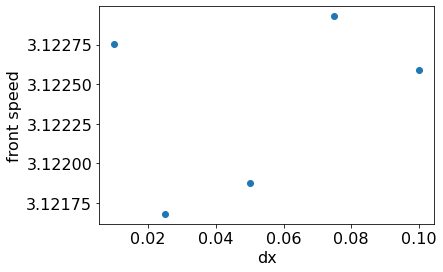

In [17]:
Da = 0.4
Omega = 0

stress = "lin"
init = "step"
bc = "fixed"

dt = 0.1
dx_list = [0.1, 0.075, 0.05, 0.025, 0.01]
xmax = 500
tmax = 100
x_save_interval = 1
t_save_interval = 1

front_speed = []

fig, ax = plt.subplots(1, len(dx_list), sharey = True, figsize = (2*len(dx_list), 2))

for i, dx in enumerate(dx_list):
    my_sim = Unique_Simulation(Da, Omega, stress, init, bc, dt, tmax, t_save_interval, dx, xmax, x_save_interval)
    front_speed.append(get_front_speed(my_sim, plot = True, ax = ax[i]))
    ax[i].set_xlabel("t")
    ax[i].set_title("dx = {:}".format(dx), fontsize = 12)

ax[0].set_ylabel("front position")
    
plt.figure()
plt.scatter(dx_list, front_speed)
plt.xlabel("dx")
plt.ylabel("front speed")

Effect of varying grid size is negligible. 

=====================Varying time step (dt)=====================

file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


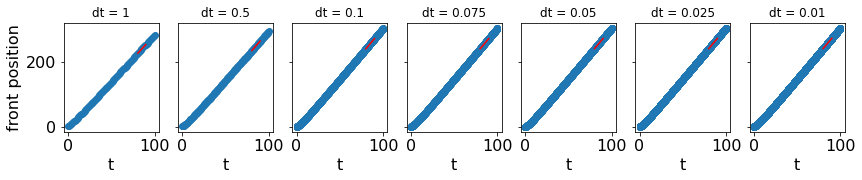

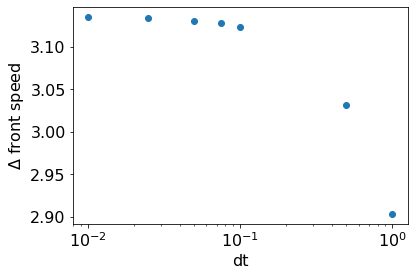

In [18]:
Da = 0.4
Omega = 0

stress = "lin"
init = "step"
bc = "fixed"

dx = 0.1
dt_list = [1, 0.5, 0.1, 0.075, 0.05, 0.025, 0.01]
xmax = 500
tmax = 100
x_save_interval = 1
t_save_interval = 1

front_speed = []

fig, ax = plt.subplots(1, len(dt_list), sharey = True, figsize = (2*len(dt_list), 2))

for i, dt in enumerate(dt_list):
    my_sim = Unique_Simulation(Da, Omega, stress, init, bc, dt, tmax, t_save_interval, dx, xmax, x_save_interval)
    front_speed.append(get_front_speed(my_sim, plot = True, ax = ax[i]))
    ax[i].set_xlabel("t")
    ax[i].set_title("dt = {:}".format(dt), fontsize = 12)

ax[0].set_ylabel("front position")
    
plt.figure()
plt.scatter(dt_list, front_speed)
plt.xlabel("dt")
plt.ylabel(r"$\Delta$ front speed")
# plt.yscale("log")
plt.xscale("log")

Below dt $\approx$ 0.05, the front speed stops changing. Below, we use dt = 0.05, tmax $\geq$ 800, dx = 0.1, and xmax large enough for the front not to hit the righthand side of the box before tmax.

=====================Reaction term=====================

Check that reaction term does not affect front speed at $\Omega = 0$

file found, loading...
front speed: 3.1567439976014127
k_0: 3.162277660168379


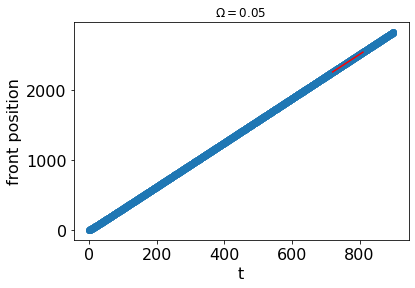

In [19]:
Da = 0.4
Omega = 0

stress = "lin"
init = "step"
bc = "fixed"
rxn = "cube"

dx = 0.1
dt = 0.05
xmax = 3000
tmax = 900 
x_save_interval = 10
t_save_interval = 10

front_speed = []

fig, ax = plt.subplots()

my_sim = Unique_Simulation(Da, Omega, stress, init, bc, dt, tmax, t_save_interval, dx, xmax, x_save_interval)
front_speed = get_front_speed(my_sim, plot = True, ax = ax)
ax.set_xlabel("t")
ax.set_title(r"$\Omega = {:}$".format(dt), fontsize = 12)
ax.set_ylabel("front position")

print("front speed: " + str(front_speed))
print("k_0: " + str(2/np.sqrt(Da)))

#### 1. Contractile stress

file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


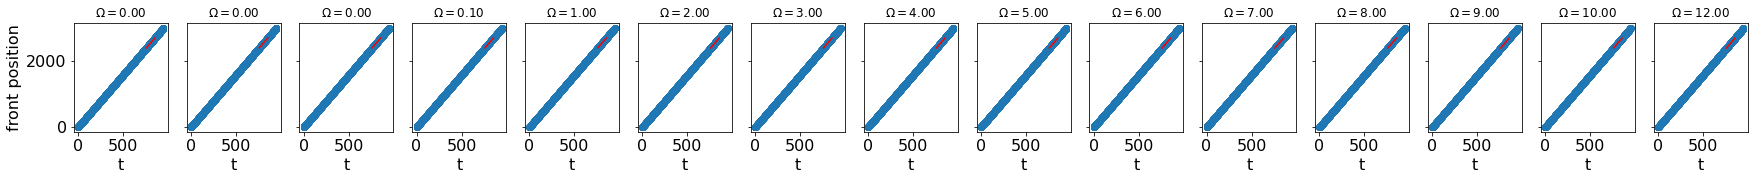

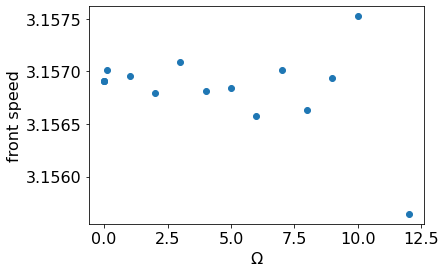

In [20]:
Da = 0.4
Omega_list = (np.logspace(-7, -1, 4)).tolist() + (np.linspace(1, 9, 9)).tolist() + [10, 12]


stress = "lin"
init = "step"
bc = "fixed"

dx = 0.1
dt = 0.05
xmax = 3000
tmax = 950 
x_save_interval = 10
t_save_interval = 10

front_speed = []

fig, ax = plt.subplots(1, len(Omega_list), sharey = True, figsize = (2*len(Omega_list), 2))

for i, Omega in enumerate(Omega_list):
    my_sim = Unique_Simulation(Da, Omega, stress, init, bc, dt, tmax, t_save_interval, dx, xmax, x_save_interval)
    front_speed.append(get_front_speed(my_sim, plot = True, ax = ax[i]))
    ax[i].set_xlabel("t")
    ax[i].set_title(r"$\Omega = {:.2f}$".format(Omega), fontsize = 12)
    
ax[0].set_ylabel("front position")

plt.figure()
plt.scatter(Omega_list, front_speed)
plt.xlabel(r"$\Omega$")
plt.ylabel("front speed")
# plt.yscale("log")
# plt.xscale("log")

np.savetxt("k_contractile_da0.4.csv", np.array(front_speed), delimiter=",")

#### 2. Extensile stress

file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


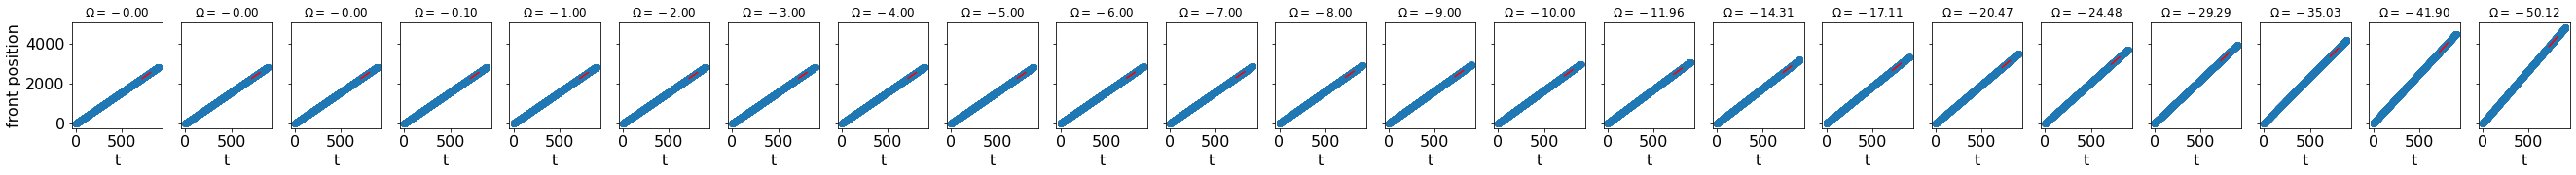

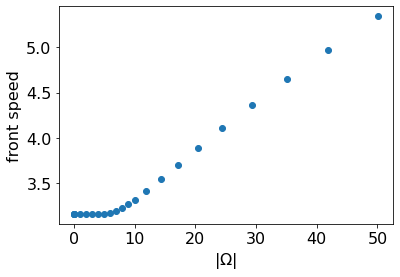

In [21]:
Da = 0.4
Omega_list = (-np.logspace(-7, -1, 4)).tolist() + (-np.linspace(1, 9, 9)).tolist() + (-np.logspace(1, 1.7, 10)).tolist()


stress = "lin"
init = "step"
bc = "fixed"

dx = 0.1
dt = 0.05
xmax_list = [3000 if np.abs(Omega) < 7 else int((2.8 + 0.058*-Omega)*1000) for Omega in Omega_list]
tmax = 900 
x_save_interval = 10
t_save_interval = 10

front_speed = []

fig, ax = plt.subplots(1, len(Omega_list), sharey = True, figsize = (2*len(Omega_list), 2))

for i, (Omega, xmax) in enumerate(zip(Omega_list, xmax_list)):
    my_sim = Unique_Simulation(Da, Omega, stress, init, bc, dt, tmax, t_save_interval, dx, xmax, x_save_interval)
    front_speed.append(get_front_speed(my_sim, plot = True, ax = ax[i]))
    ax[i].set_xlabel("t")
    ax[i].set_title(r"$\Omega = {:.2f}$".format(Omega), fontsize = 12)

ax[0].set_ylabel("front position")

plt.figure()
plt.scatter(-1*np.array(Omega_list), front_speed)
plt.xlabel(r"$|\Omega|$")
plt.ylabel("front speed")
# plt.yscale("log")
# plt.xscale("log")

np.savetxt("k_extensile_da0.4.csv", np.array(front_speed), delimiter=",")

=================Plot Extensile vs Contractile=====================

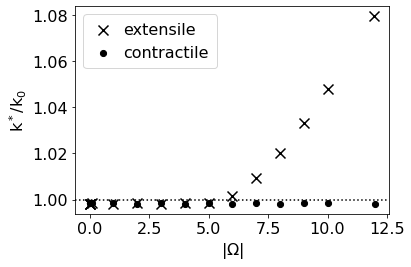

In [22]:
Omega_list = (-np.logspace(-7, -1, 4)).tolist() + (-np.linspace(1, 9, 9)).tolist() + (-np.logspace(1, 1.7, 10)).tolist()
ext = np.loadtxt('k_extensile_da0.4.csv')
plt.scatter(np.abs(Omega_list[:-8]), np.array(ext[:-8])/(2/np.sqrt(0.4)), color = 'k', marker = 'x', label = 'extensile', s = 100)

Omega_list = (np.logspace(-7, -1, 4)).tolist() + (np.linspace(1, 9, 9)).tolist() + [10, 12]
con = np.loadtxt('k_contractile_da0.4.csv')
plt.scatter(np.abs(Omega_list), np.array(con)/(2/np.sqrt(0.4)), color = 'k', marker = '.', label = 'contractile', s = 150)

plt.axhline(1, c = 'k', ls = ':')

plt.xlabel(r"$|\Omega|$")
plt.ylabel(r'$k^*/k_0$')
#plt.ylim(3.14, 3.5)
plt.legend(handletextpad = 0.5, borderpad = 0.5, handlelength = 1.5, loc = 2)

plt.tight_layout()
plt.savefig('Plots/k-ext-con.pdf')

#### 3. Extensile stresses, varying Da

=================== Da = 0.2 =======================

file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


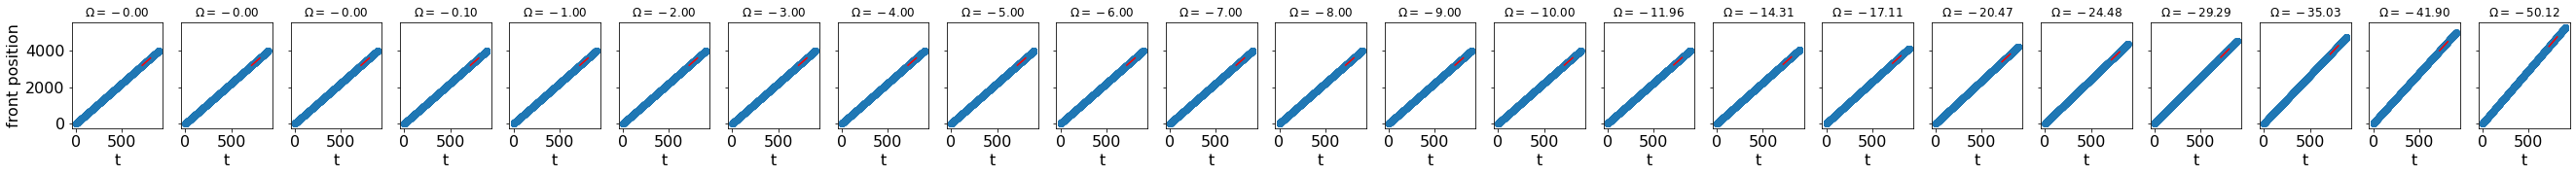

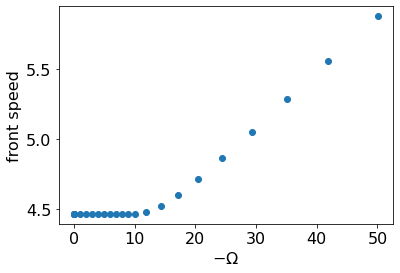

In [23]:
factor = np.sqrt(2)
Da = 0.4/2
Omega_list = (-np.logspace(-7, -1, 4)).tolist() + (-np.linspace(1, 9, 9)).tolist() + (-np.logspace(1, 1.7, 10)).tolist()

stress = "lin"
init = "step"
bc = "fixed"

dx = 0.1*factor
dt = 0.05
xmax_list = factor*np.array([3000 if np.abs(Omega) < 7 else int((2.8 + 0.058*-Omega)*1000) for Omega in Omega_list])
tmax = 900 
x_save_interval = 10
t_save_interval = 10

front_speed = []

fig, ax = plt.subplots(1, len(Omega_list), sharey = True, figsize = (2*len(Omega_list), 2))

for i, (Omega, xmax) in enumerate(zip(Omega_list, xmax_list)):
    my_sim = Unique_Simulation(Da, Omega, stress, init, bc, dt, tmax, t_save_interval, dx, xmax, x_save_interval)
    front_speed.append(get_front_speed(my_sim, plot = True, ax = ax[i]))
    ax[i].set_xlabel("t")
    ax[i].set_title(r"$\Omega = {:.2f}$".format(Omega), fontsize = 12)

ax[0].set_ylabel("front position")

plt.figure()
plt.scatter(-1*np.array(Omega_list), front_speed)
plt.xlabel(r"$-\Omega$")
plt.ylabel("front speed")
# plt.yscale("log")
# plt.xscale("log")

np.savetxt("k_extensile_da0.2.csv", np.array(front_speed), delimiter=",")

===================== Da = 0.8 =====================

file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


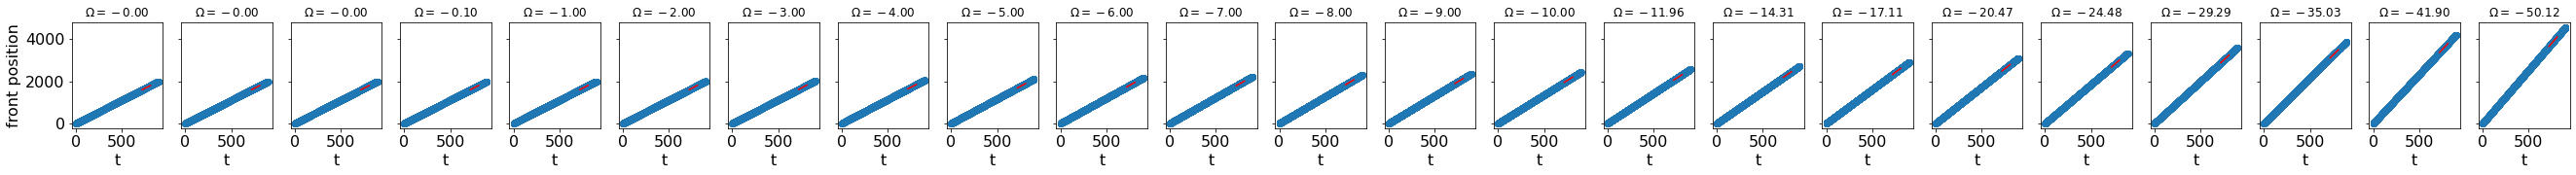

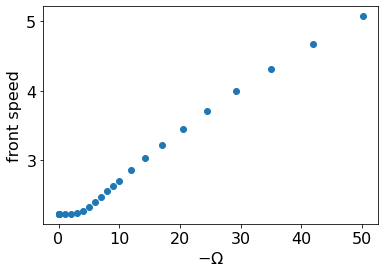

In [24]:
factor = 1./np.sqrt(2)
Da = 2*0.4
Omega_list = (-np.logspace(-7, -1, 4)).tolist() + (-np.linspace(1, 9, 9)).tolist() + (-np.logspace(1, 1.7, 10)).tolist()


stress = "lin"
init = "step"
bc = "fixed"

dx = 0.1*factor
dt = 0.05
xmax_list = factor*np.array([3000 if np.abs(Omega) < 6 else int((3 + 0.075*-Omega)*1000) for Omega in Omega_list])
tmax = 900 
x_save_interval = 10
t_save_interval = 10

front_speed = []

fig, ax = plt.subplots(1, len(Omega_list), sharey = True, figsize = (2*len(Omega_list), 2))

for i, (Omega, xmax) in enumerate(zip(Omega_list, xmax_list)):
    my_sim = Unique_Simulation(Da, Omega, stress, init, bc, dt, tmax, t_save_interval, dx, xmax, x_save_interval)
    front_speed.append(get_front_speed(my_sim, plot = True, ax = ax[i]))
    ax[i].set_xlabel("t")
    ax[i].set_title(r"$\Omega = {:.2f}$".format(Omega), fontsize = 12)

ax[0].set_ylabel("front position")

plt.figure()
plt.scatter(-1*np.array(Omega_list), front_speed)
plt.xlabel(r"$-\Omega$")
plt.ylabel("front speed")
# plt.yscale("log")
# plt.xscale("log")

np.savetxt("k_extensile_da0.8.csv", np.array(front_speed), delimiter=",")

==================== Plot results from ODE (generated using matlab code in this repo) and full simulation =====================

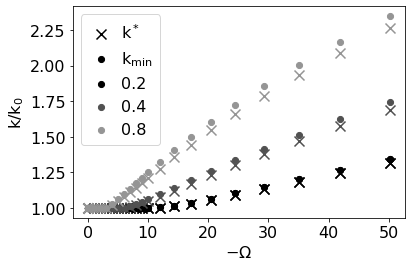

In [25]:
colormap = cm.get_cmap('Greys')
colors = [colormap(x) for x in np.linspace(1, 0.5, 3)]
Omega_list = (-np.logspace(-7, -1, 4)).tolist() + (-np.linspace(1, 9, 9)).tolist() + (-np.logspace(1, 1.7, 10)).tolist()

for Da, c in zip([0.2], colors):
    k0 = 2/np.sqrt(Da)
    full_sim = np.loadtxt('k_extensile_da{:.1}.csv'.format(Da))
    nm_sim = np.loadtxt('kmin_nm_da{:.1}.csv'.format(Da), delimiter=',')
    plt.scatter(np.abs(Omega_list), np.array(full_sim)/k0, color = c, marker = 'x', label = r'$k^*$', s = 100)
    plt.scatter(np.abs(Omega_list), np.array(nm_sim)/k0, marker = '.', color = c, label = r'$k_{min}$', s = 150)

for Da, c in zip([0.2, 0.4, 0.8], colors):
    k0 = 2/np.sqrt(Da)
    full_sim = np.loadtxt('k_extensile_da{:.1}.csv'.format(Da))
    nm_sim = np.loadtxt('kmin_nm_da{:.1}.csv'.format(Da), delimiter=',')
    plt.scatter(np.abs(Omega_list), np.array(full_sim)/k0, color = c, marker = 'x', s = 100)
    plt.scatter(np.abs(Omega_list), np.array(nm_sim)/k0, marker = '.', color = c, label = Da, s = 150)

plt.xlabel(r"$-\Omega$")
plt.ylabel(r'$k/k_0$')
plt.legend(handletextpad = 0.5, borderpad = 0.5, handlelength = 1.5, loc = 2)

plt.tight_layout()
plt.savefig('Plots/k-vs-omega.pdf')

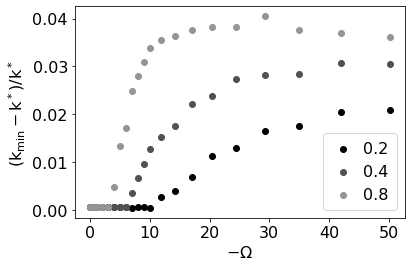

In [26]:
colormap = cm.get_cmap('Greys')
colors = [colormap(x) for x in np.linspace(1, 0.5, 3)]
Omega_list = (-np.logspace(-7, -1, 4)).tolist() + (-np.linspace(1, 9, 9)).tolist() + (-np.logspace(1, 1.7, 10)).tolist()

for Da, c in zip([0.2, 0.4, 0.8], colors):
    full_sim = np.loadtxt('k_extensile_da{:.1}.csv'.format(Da))
    nm_sim = np.loadtxt('kmin_nm_da{:.1}.csv'.format(Da), delimiter=',')
    plt.scatter(np.abs(Omega_list), np.abs(np.array(full_sim) - np.array(nm_sim))/np.array(full_sim), color = c, label = Da)
plt.xlabel(r"$-\Omega$")
plt.ylabel(r'$(k_{min} - k^*)/k^*$')
plt.legend(handletextpad = 0.5, borderpad = 0.5, handlelength = 1.5, loc = 4)

plt.tight_layout()
plt.savefig('Plots/k-rel-error-vs-omega.pdf')

## Figs 1, 5, 7, bottom of 6  : instability 

#### 1. Plot prediction for $\sigma(q)$ from linear stability analysis

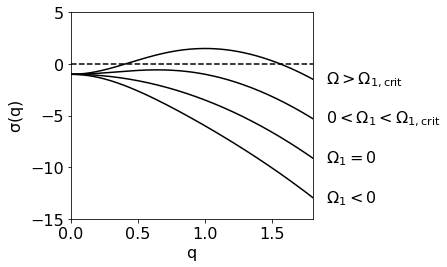

In [27]:
Omega_list = [-5, 0, 5, 10]
colormap = cm.get_cmap('viridis')
colors = [colormap(x) for x in np.linspace(0, 1, len(Omega_list))]
fig, ax = plt.subplots(figsize = (6.5, 4))

x = np.arange(-1, 2, 0.01)
    
ax.axhline(0, c = 'k', ls = '--')

labels = [r'$\Omega_1 < 0$', r'$\Omega_1 = 0$', r'$0<\Omega_1 < \Omega_{1, crit}$', r'$\Omega > \Omega_{1, crit}$']
for Omega, label in zip(Omega_list, labels):
    ax.plot(x, sigma(0.4, Omega, x), label = Omega, c = 'k')
    ax.text(s=label, x=1.9, y=sigma(0.4, Omega, 1.8), verticalalignment = 'center')


ax.set_xlabel("q")
ax.set_ylabel(r"$\sigma(q)$")
ax.set_xlim(0, 1.8)
ax.set_ylim(-15, 5)
fig.set_tight_layout(True)
plt.savefig('Plots/lsa_sigma_q.pdf')

#### 2. Determine $\Omega_{c}$ and $q_c$ from simulations w/ PBC at several box sizes and compare to prediction from LSA

========================= Run simulations and find $\Omega_c$ and $q_c$ ======================= 

<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


<ipython-input-30-587053ac7cb9>:72: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


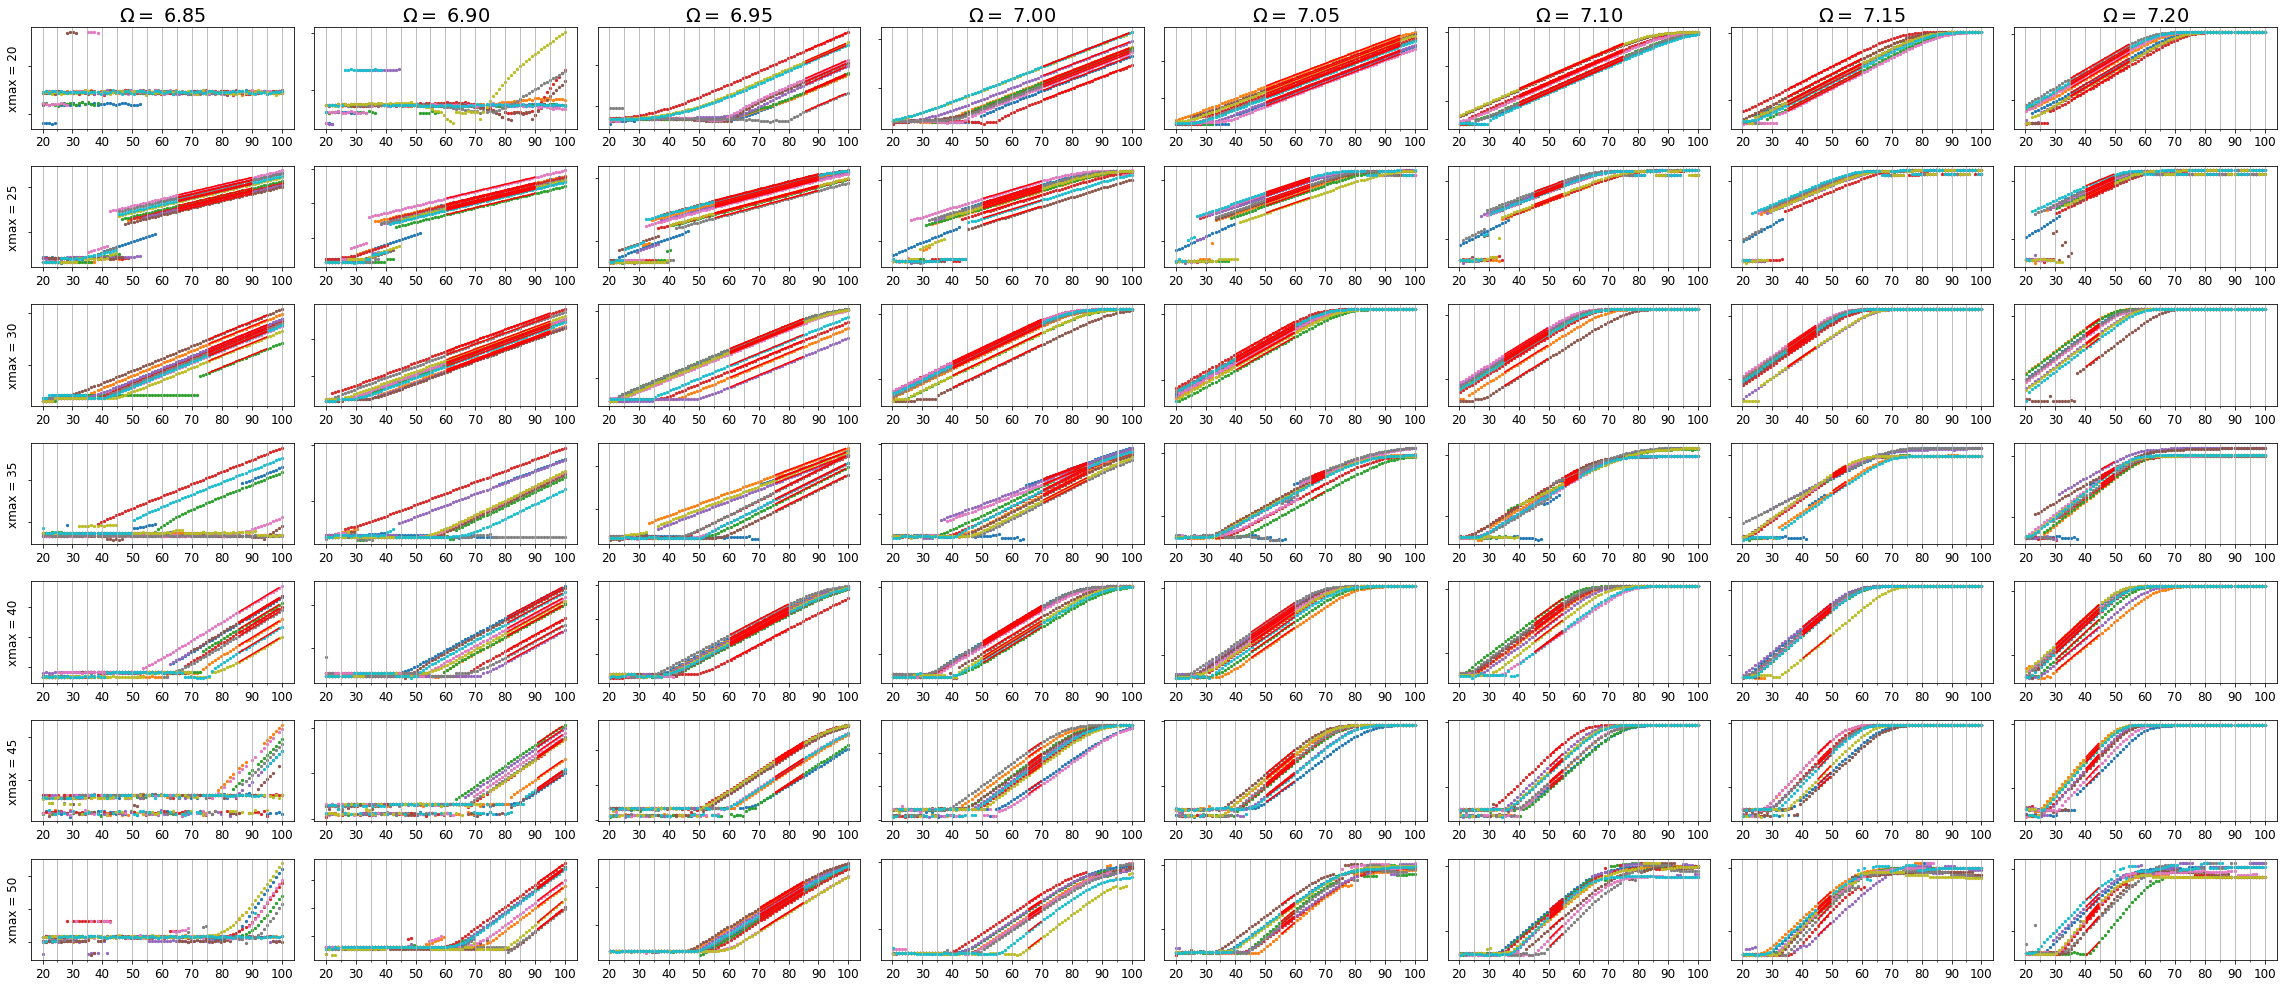

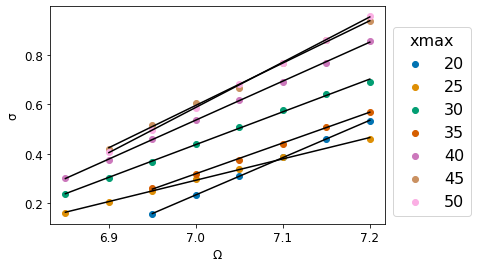

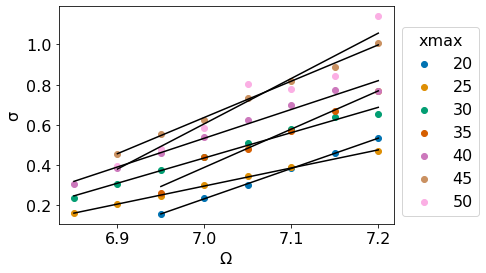

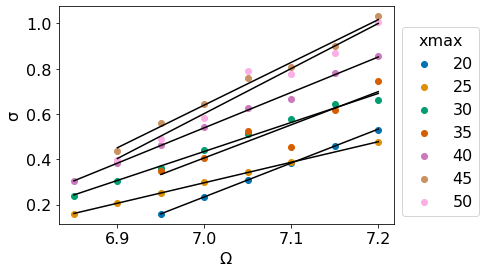

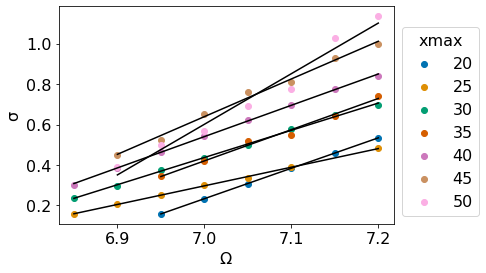

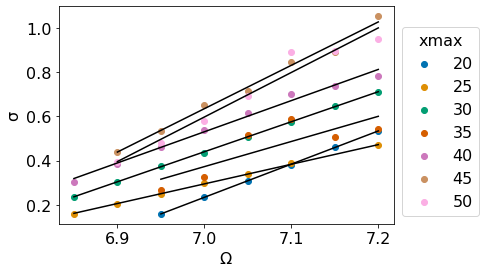

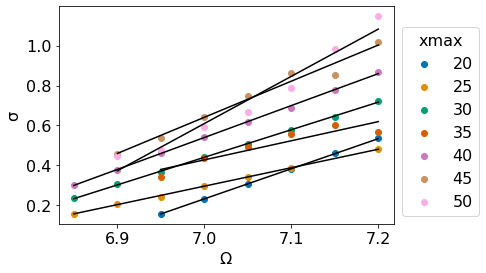

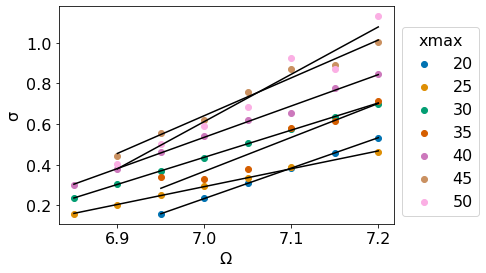

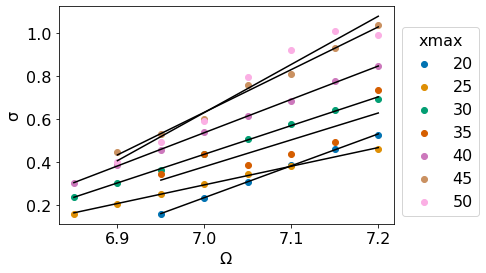

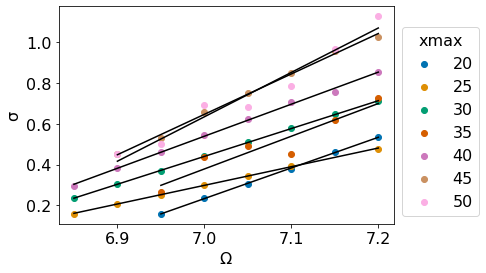

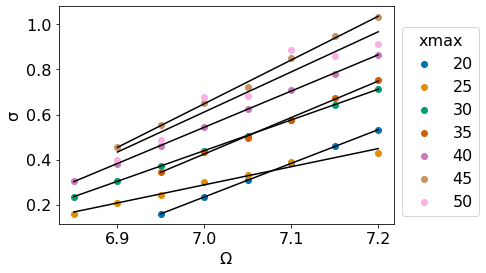

In [30]:
Da = 0.4
Omega_list = np.arange(6.85, 7.21, 0.05)

stress = "lin"
init = "pert"
bc = "pbc"

dx = 0.01
dt = 0.1
xmax_list = np.arange(20, 51, 5)
tmax = 100 
x_save_interval = 1
t_save_interval = 10 

#limits for fitting log(h) vs t. these were found by eye from plots of log(h) vs t and may need to be changed for a new set of simulations.

##Omega   6.85  6.9  6.95  7    7.05  7.1  7.15  7.2
t_min =  [[-1,   -1,  85,   70,  50,   40,  35,   35], #xmax = 20
         [65,   60,  55,   50,  50,   45,  50,   40], #xmax = 25
         [75,   60,  60,   40,  40,   35,  35,   40], #xmax = 30
         [-1,   -1,  75,   70,  65,   55,  50,   45], #xmax = 35
         [85,   80,  60,   50,  45,   45,  40,   30], #xmax = 40
         [-1,   90,  75,   65,  50,   50,  45,   40], #xmax = 45
         [-1,   90,  70,   65,  55,   50,  45,   40]] #xmax = 50
        
t_max =  [[-1,   -1,  99,   99,  95,   75,  60,   55], #xmax = 20
         [90,   90,  90,   70,  65,   55,  50,   50], #xmax = 25
         [95,   95,  85,   70,  60,   50,  45,   45], #xmax = 30
         [-1,   -1,  99,   85,  70,   60,  55,   50], #xmax = 35
         [99,   99,  80,   70,  60,   55,  50,   45], #xmax = 40
         [-1,   99,  85,   70,  60,   55,  50,   45], #xmax = 45
         [-1,   99,  85,   70,  60,   55,  50,   45]] #xmax = 50


rcParams['font.size'] = 12
colors = sns.color_palette("colorblind")

#these lists will hold results from several repeated simulations with same parameters but different realizations of random initial conditions. 
#the value of omega_crit from simulation no. k of xmax_list[i] of Omega_list[j] is in position omega_crit_many[k][i][j]
omega_crit_many = []
omega_exp_many = []
sigma_exp_many = []
q_max_exp_many = []

#set to True to plot t vs max amplitude of ft for each i, j, k
plot_t_vs_maxh = True

if plot_t_vs_maxh:
    fig, ax = plt.subplots(len(xmax_list), len(Omega_list), figsize = (4*len(Omega_list), 2*len(xmax_list)), sharex = True)

for k in range(10):
    
    omega_crit = []
    omega_exp = []
    sigma_exp = []
    q_max_exp = []

    #set to True to plot sigma vs omega for each k
    plot_sigma_vs_omega = True
    #set to True to plot q_max vs omega for each k
    plot_qmax_vs_omega = False
    
    if plot_sigma_vs_omega:
        fig1, ax1 = plt.subplots()
    if plot_qmax_vs_omega:
        fig2, ax2 = plt.subplots()

    for i, (xmax, c) in enumerate(zip(xmax_list, colors)):

            n = int(xmax / dx)
            freq = np.linspace(0.0, 1.0/(2.0*dx), n//2)
            wl = 1/freq

            omega_plot = []
            sigma_plot = []
            q_max = []

            for j, Omega in enumerate(Omega_list):

                    my_sim = Repeat_Simulation(Da, Omega, stress, init, bc, dt, tmax, t_save_interval, dx, xmax, x_save_interval, 10)
                    #ft concentration from simulation #k
                    fts = [fft(sol_c - np.mean(sol_c)) for sol_c in my_sim.sol_c[k]]

                    #identify highest peak at late times
                    peaks_alltimes = [signal.find_peaks(np.abs(ft[:n//2]), height = 0) for ft in fts]
                    highest_peak_index = peaks_alltimes[-1][0][np.argmax(peaks_alltimes[-1][1]['peak_heights'])]
                    #get height of that peak over time and plot
                    highest_peak_height = [peaks[1]['peak_heights'][highest_peak_index] for peaks in peaks_alltimes]
                    if plot_t_vs_maxh:
                        ax[i, j].scatter(my_sim.t[20:], np.log(highest_peak_height[20:]), s = 5)

                        #format the plots of t vs log(peak height)
                        ax[i, j].set(yticklabels=[])
                        if i == 0:
                            ax[i, j].set_title(r"$\Omega = $ {:.2f}".format(Omega))
                        if j == 0:
                            ax[i, j].set_ylabel("xmax = {:.0f}".format(xmax))
                        ax[i, j].xaxis.set_tick_params(which='major', labelbottom=True)
                        ax[i, j].xaxis.set_major_locator(MultipleLocator(10))
                        ax[i, j].xaxis.set_major_formatter(FormatStrFormatter('%d'))
                        ax[i, j].xaxis.set_minor_locator(MultipleLocator(5))
                        ax[i, j].xaxis.grid(True, which = 'both')

                    #fit linear region of t vs log(peak height)
                    if t_min[i][j] != -1 and t_min[i][j] < t_max[i][j]:
                        z, pcov = curve_fit(line, my_sim.t[t_min[i][j]:t_max[i][j]], np.log(highest_peak_height[t_min[i][j]:t_max[i][j]]))
                        sigma_plot.append(z[0])
                        omega_plot.append(Omega)
                        q_max.append(2*np.pi/wl[highest_peak_index])
                        if plot_t_vs_maxh:
                            ax[i, j].plot(my_sim.t[t_min[i][j]:t_max[i][j]], line(my_sim.t[t_min[i][j]:t_max[i][j]], *z), c = 'r')

            if plot_t_vs_maxh:
                fig.set_tight_layout(True)

            #plot \Omega vs sigma and find y-intercept = \omega_critical

            if plot_sigma_vs_omega:
                ax1.scatter(omega_plot, sigma_plot, label = xmax, color = c)
            omega_exp.append(omega_plot)
            sigma_exp.append(sigma_plot)
            z, pcov = curve_fit(line, omega_plot, sigma_plot)
            if plot_sigma_vs_omega:
                ax1.plot(omega_plot, line(np.array(omega_plot), *z), c = 'k')
            omega_crit.append(-z[1]/z[0])

            if plot_qmax_vs_omega:
                ax2.scatter(omega_plot, q_max, label = xmax, color = c)
            q_max_exp.append(q_max)

    q_max_exp_many.append(q_max_exp)
    omega_exp_many.append(omega_exp)
    sigma_exp_many.append(sigma_exp)
    omega_crit_many.append(omega_crit)

    if plot_t_vs_maxh:
        fig.savefig('Plots/h_vs_t_grid_all.pdf')

    rcParams['font.size'] = 16

    if plot_sigma_vs_omega:
        ax1.legend(title = 'xmax', ncol = 1, loc = 3, bbox_to_anchor = (1, 0))
        ax1.set_xlabel(r"$\Omega$")
        ax1.set_ylabel(r"$\sigma$")

    if plot_qmax_vs_omega:
        ax2.legend(title = 'xmax', ncol = 1, loc = 3, bbox_to_anchor = (1, 0))
        ax2.set_xlabel(r"$\Omega$")
        ax2.set_ylabel(r"$q_1$")        
    

with open("q_max_exp.txt", "wb") as fp:
    pickle.dump(q_max_exp_many, fp)

with open("omega_exp.txt", "wb") as fp:
    pickle.dump(omega_exp_many, fp)
    
with open("sigma_exp.txt", "wb") as fp:
    pickle.dump(sigma_exp_many, fp)
    
with open("omega_crit_exp.txt", "wb") as fp:
    pickle.dump(omega_crit_many, fp) 

#takes a while -- play a sound to alert me when finished
allDone()

======================= Plot ==========================

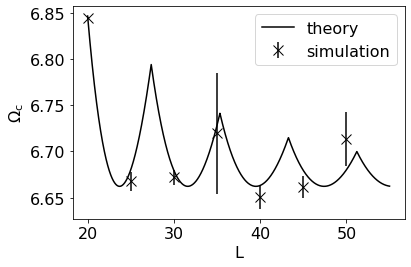

In [31]:
xmax_list = np.arange(20, 51, 5)
xmax_list_lsa = np.arange(20, 55, 0.01)
omega_crit_lsa = np.zeros(len(xmax_list_lsa))
with open("omega_crit_exp.txt", "rb") as fp:
    omega_crit_exp = pickle.load(fp)

fig = plt.figure(figsize = (6, 4))
for i, xmax in enumerate(xmax_list_lsa):
    omega_crit_lsa[i] = np.amin(np.array([omega_crit_q(0.4, q_discrete(xmax, n)) for n in np.arange(1, 20)]))

plt.plot(xmax_list_lsa, omega_crit_lsa, c = 'k', label = 'theory')
plt.errorbar(xmax_list, np.mean(omega_crit_exp, axis = 0), yerr = np.std(omega_crit_exp, axis = 0), fmt = '.', c = 'k', marker = 'x', ms = 10, label = 'simulation')
plt.xlabel('L')
plt.ylabel(r'$\Omega_c$')
plt.legend()

plt.tight_layout()
plt.savefig("Plots/omega_crit_vs_xmax.pdf")

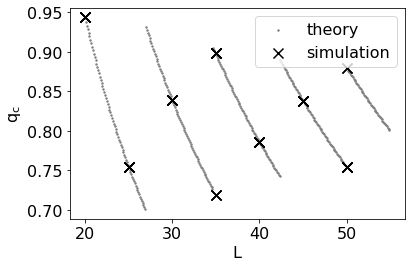

In [35]:
with open("q_max_exp.txt", "rb") as fp:
    temp = pickle.load(fp)
    
q_max_exp = []
xmax_exp = []

#pick out q_max for Omega = 6.95
for i, xmax in enumerate(xmax_list):
    for k in range(10):
        xmax_exp.append(xmax)
        q_max_exp.append(temp[k][i][2])
    
xmax_list_lsa = np.arange(20, 55, 0.1)
q_max_lsa_list = np.zeros(len(xmax_list_lsa))

Da = 0.4
Omega = 6.95

for i, xmax in enumerate(xmax_list_lsa):
    q_max_lsa_list[i] = qmax_discrete(Omega, Da, xmax)

fig = plt.figure(figsize = (6, 4))
plt.scatter(xmax_list_lsa, q_max_lsa_list, c = 'grey', s = 2, label = 'theory')
plt.scatter(xmax_exp, q_max_exp, c = 'k', marker = 'x', s = 100, label = 'simulation')
plt.xlabel('L')
plt.ylabel(r'$q_c$')
plt.legend()

plt.tight_layout()
plt.savefig("Plots/qmax_vs_xmax_Omega6.95.pdf")

#### 2. Find $\Omega_c$ and $q_c$ in simulations with a front

====================Find $\Omega_c$========================

file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


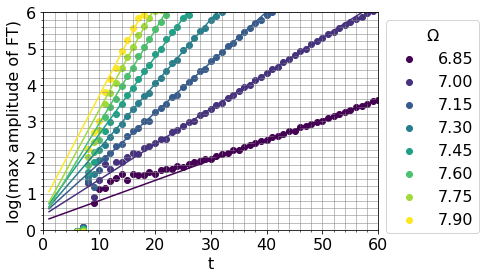

In [33]:
Da = 0.4
Omega_list = np.arange(6.85, 8, 0.15)
colormap = cm.get_cmap('viridis')
colors = [colormap(x) for x in np.linspace(0, 1, len(Omega_list))]

sigma_list = []

stress = "lin"
init = "step"
bc = "fixed"

dx = 0.01
dt = 0.1
xmax = 500
tmax = 150 
x_save_interval = 1
t_save_interval = 10

tlist = np.arange(1, 150, 1)
tmin_fit_list = [40, 20, 15, 12, 12, 12, 12, 12]
tmax_fit_list = [80, 50, 35, 30, 26, 22, 20, 18]

plot_amp_vs_t = True

if plot_amp_vs_t == True:
    fig, ax = plt.subplots()

for Omega, tmin_fit, tmax_fit, c in zip(Omega_list, tmin_fit_list, tmax_fit_list, colors):

    my_sim = Unique_Simulation(Da, Omega, stress, init, bc, dt, tmax, t_save_interval, dx, xmax, x_save_interval)
    all_peaks = [signal.find_peaks(my_sim.sol_c[int(t/(dt * t_save_interval))], height = 1.0001)[0] for t in tlist]

    #fft from left side of box to location of peak closest to the interface
    right_cutoffs = [peaks[-1] if len(peaks) > 0 else -1 for peaks in all_peaks]
    instab = [peaks[-3] if len(peaks) > 2 else -1 for peaks in all_peaks]
    
    fts = [0 if right_cutoff == -1 else fft(sol_c[:right_cutoff] - np.mean(sol_c[:right_cutoff])) for (sol_c, right_cutoff) in zip(my_sim.sol_c[tlist], right_cutoffs)]
    #get max amplitude of FT as a function of time
    my_t = []
    hmax = []
    for i, (t, ft) in enumerate(zip(tlist, fts)):
        n = right_cutoffs[i]
        if n > 1:
            my_t.append(t)
            hmax.append(np.amax(np.abs(ft)))
    my_t = np.array(my_t)
    hmax = np.array(hmax)
    if plot_amp_vs_t:
        ax.scatter(my_t, np.log(hmax), color = c, label = '{:.2f}'.format(Omega))
    tmin_ind = np.where(my_t > tmin_fit)[0][0]
    tmax_ind = np.where(my_t > tmax_fit)[0][0]
    z, pcov = curve_fit(line, my_t[tmin_ind:tmax_ind], np.log(hmax[tmin_ind:tmax_ind]))
    sigma_list.append(z[0])
    if plot_amp_vs_t:
        ax.plot(my_t, line(my_t, *z), color = c)
        
if plot_amp_vs_t:    
    ax.set_xlabel('t')
    ax.set_ylabel('log(max amplitude of FT)')
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 6)
    ax.minorticks_on()
    ax.grid(which = 'both', color='gray', linestyle='-', linewidth=0.5)
    ax.legend(title = r'$\Omega$', loc = 2, bbox_to_anchor=(1, 1))

$\Omega_c$, front simulations:  6.6325337635102395
$\Omega_c$, fitting lsa values of $\sigma$:  6.669776728236075


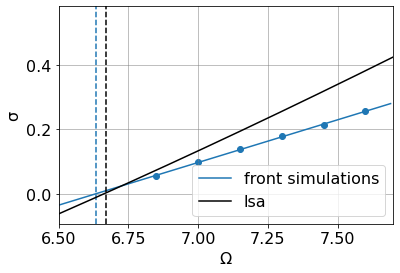

In [41]:
z, pcov = curve_fit(line, Omega_list[:-2], sigma_list[:-2])
print(r"$\Omega_c$, front simulations: ", -z[1]/z[0])

plt.scatter(Omega_list, sigma_list)
plt.plot(np.arange(6.4, 7.7, 0.01), line(np.arange(6.4, 7.7, 0.01), *z), label = 'front simulations')
plt.axvline(-z[1]/z[0], ls = '--')

Omega_list_theory = np.arange(6.5, 8, 0.01)
Da = 0.4
plt.plot(Omega_list_theory, sigma(Da, Omega_list_theory, q_max_lsa(Da, Omega_list_theory)), c = 'k', label = 'lsa')
z2, pcov2 = curve_fit(line, Omega_list_theory, sigma(Da, Omega_list_theory, q_max_lsa(Da, Omega_list_theory)))
print(r"$\Omega_c$, fitting lsa values of $\sigma$: ", -z2[1]/z2[0])
plt.axvline(-z2[1]/z2[0], c = 'k', ls = '--')

plt.grid(which = 'both', color='gray', linestyle='-', linewidth=0.5)
plt.xlabel(r"$\Omega$")
plt.ylabel(r"$\sigma$")
plt.xlim(6.5, 7.7)
plt.legend()

========================= Function to find q_1 ========================

In [42]:
###note: t_min_save sets the time at which to start saving the trajectory. 
#For long trajectories where we might need only the long time behavior this saves memory and makes the file faster to load later.
#Here, I use this parameter to concatenate results from shorter trajectories with smaller box sizes (t_min_save = 0) to 
#longer trajectories with larger boxes (t_min_save > 0)

def get_q1_vs_t(t_min_save, tmax, xmax, stress = 'lin', Omega_list = np.arange(6.85, 8, 0.15), dx = 0.05, fname = "q1_front_sims_t"):

    Da = 0.4
    
    init = "step"
    bc = "fixed"
    
    dt = 0.05
    x_save_interval = int(0.05/dx)
    t_save_interval = int(2./dt)

    #these arrays hold the wavelength with the maximum amplitude in the ft of the concentration as a fxn of time. max_wls[i][j] holds the max_wl for Omega[i], at time t[j].
    q1s = []
    t1 = []

    plot_x = False
    plot_fts = False

    for Omega in Omega_list:

        my_sim = Unique_Simulation(Da, Omega, stress, init, bc, dt, tmax, t_save_interval, dx, xmax, x_save_interval, t_min_save = t_min_save)
        all_peaks = [signal.find_peaks(c, height = 1.0001)[0] for c in my_sim.sol_c]

        #fft from left side of box to location of peak closest to the interface
        right_cutoffs = [peaks[-1] if len(peaks > 0) else -1 for peaks in all_peaks]
        fts = [0 if right_cutoff == -1 else fft(sol_c[:right_cutoff] - np.mean(sol_c[:right_cutoff])) for (sol_c, right_cutoff) in zip(my_sim.sol_c, right_cutoffs)]

        if plot_x:
            my_sim.plot_c(tmax - 1)
            plt.axvline(x = right_cutoffs[-1]* dx * x_save_interval, c = 'k')

        #plot fft and get peak wavelength of fft at at all times
        #since the region that we are FTing changes over time, I need to do several checks to make sure that it's large enough to get reasonable results
        t2 = []
        q1s_t = []

        if plot_fts:
            fig1, ax1 = plt.subplots()

        t_start_index = 20
        for j, (t, ft) in enumerate(zip(my_sim.t[t_start_index:], fts[t_start_index:])):      
            i = j + t_start_index
            n = right_cutoffs[i]
            if n > 1:
                freq = np.linspace(0.0, 1.0/(2.0*dx*x_save_interval), n//2)
                wl = 1/freq
                if len(np.where(wl < 2*np.pi)[0]) > 0:
                    ind_hi = np.where(wl < 2*np.pi)[0][0]
                    ind_lo = np.where(wl < 2*np.pi/0.5)[0][0]
                    if ind_hi - ind_lo > 0:
                        peaks = signal.find_peaks(np.abs(ft[ind_lo:ind_hi]), height = 0.1)
                        if len(peaks[1]['peak_heights'] > 0):
                            highest_peak_index = np.argmax(peaks[1]['peak_heights'])
                            highest_peak_wl = wl[ind_lo + peaks[0][highest_peak_index]]
                            q1s_t.append(2*np.pi/highest_peak_wl)
                            t2.append(t)
                            if plot_fts and t%50 == 0:
                                ax1.plot(wl, np.abs(ft[:n//2]), label = t)#, color = c[i])

        q1s.append(q1s_t)
        t1.append(t2)

        if plot_fts:
            ax1.legend(title = 't', loc = 2, bbox_to_anchor=(1, 1))
            ax1.set_xlim(5, 8.5)
            ax1.set_xlabel("wavelength")
            ax1.set_ylabel("fft(c)")
            ax1.set_title("{:.2f}".format(Omega))

    with open("{:}{:d}-{:d}.txt".format(fname, t_min_save, tmax), "wb") as f:
        pickle.dump([t1, q1s], f)

========================= Run and find q_1 with different stresses ========================

$\zeta_c \propto c$

In [43]:
get_q1_vs_t(0, 600, 2100)
get_q1_vs_t(600, 1800, 6300)

file found, loading...


<ipython-input-42-3cd229dfe42e>:51: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


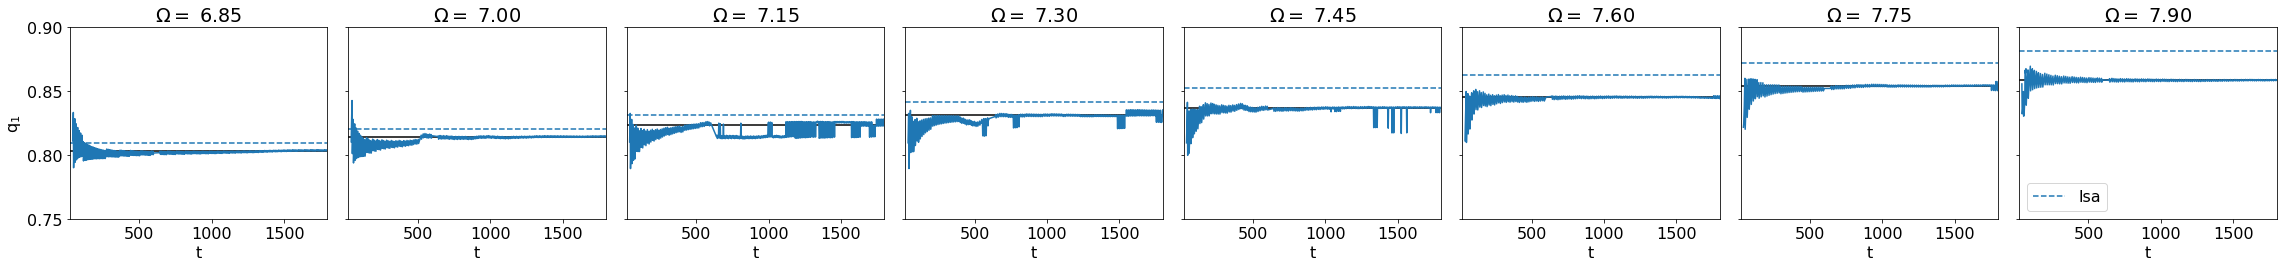

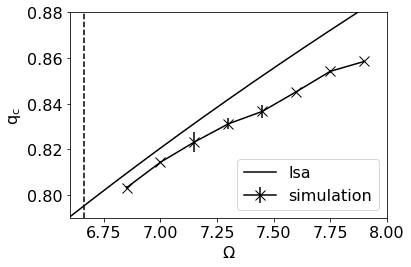

In [44]:
Da = 0.4
Omega_list = np.arange(6.85, 8, 0.15)
pred_q_lsa_list = [q_max_lsa(Omega, Da) for Omega in Omega_list]

#load results for each chunk of time
with open("q1_front_sims_t0-600.txt", "rb") as f:
    t_1, q1_1 = pickle.load(f)

with open("q1_front_sims_t600-1800.txt", "rb") as f:
    t_2, q1_2 = pickle.load(f)

#plot q_1 vs t
fig, ax = plt.subplots(nrows=1, ncols=len(Omega_list), figsize=(4*len(Omega_list), 4), sharey = True)

last = len(Omega_list) - 1
q1_late_times = []
q1_late_times_std = []

for i, (Omega, pred_q_lsa) in enumerate(zip(Omega_list, pred_q_lsa_list)):
    t = np.array(t_1[i] + t_2[i])
    q1 = np.array(q1_1[i] + q1_2[i])
    ax[i].set_xlim(20, 1800)
    ax[i].set_ylim(0.75, 0.9)
    ax[i].axhline(pred_q_lsa, ls = '--', label = 'lsa' if i == last else None)
    #get mean and standard deviation of last 1/3 of q_1 values
    q1_late_times.append(np.mean(q1[2*int(len(q1)/3):]))
    q1_late_times_std.append(np.std(q1[2*int(len(q1)/3):]))
    ax[i].axhline(np.mean(q1[int(2*len(q1)/3):]), c = 'k')
    ax[i].plot(t, q1)
    ax[i].set_title(r"$\Omega = $ {:.2f}".format(Omega))
    ax[i].set_xlabel('t')
    

ax[0].set_ylabel(r'$q_1$')
ax[last].legend()
fig.set_tight_layout(True)
fig.savefig('Plots/q1_vs_t_front.pdf')

# plot q_c vs \Omega

fig = plt.figure(figsize = (6, 4))

plt.errorbar(Omega_list, q1_late_times, yerr = q1_late_times_std, c = 'k', marker = 'x', ms = 10, label = 'simulation')
plt.plot(np.arange(6.5, 8.1, 0.01), q_max_lsa(np.arange(6.5, 8.1, 0.01), Da), c = 'k', label = 'lsa')
plt.axvline(omega_crit_inf(0.4), ls='--', c='k')
plt.xlim(6.6, 8)
plt.ylim(0.79, 0.88)
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$q_c$')
plt.legend()
plt.tight_layout()
fig.savefig('Plots/qc_vs_Omega_front.pdf')

$\zeta_c \propto c/(1+c)$

In [45]:
get_q1_vs_t(0, 600, 2100, stress = 'sat', Omega_list = 3.5*np.arange(7.75, 8.3, 0.15), dx = 0.01, fname = "q1_front_sims_sat_stress_t")
get_q1_vs_t(600, 1200, 4200, stress = 'sat', Omega_list = 3.5*np.arange(7.75, 8.3, 0.15), dx = 0.01, fname = "q1_front_sims_sat_stress_t")
get_q1_vs_t(1200, 1800, 6300, stress = 'sat', Omega_list = 3.5*np.arange(7.75, 8.3, 0.15), dx = 0.01, fname = "q1_front_sims_sat_stress_t")
get_q1_vs_t(1800, 2400, 8400, stress = 'sat', Omega_list = 3.5*np.arange(7.75, 8.3, 0.15), dx = 0.01, fname = "q1_front_sims_sat_stress_t")

file found, loading...


<ipython-input-42-3cd229dfe42e>:51: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


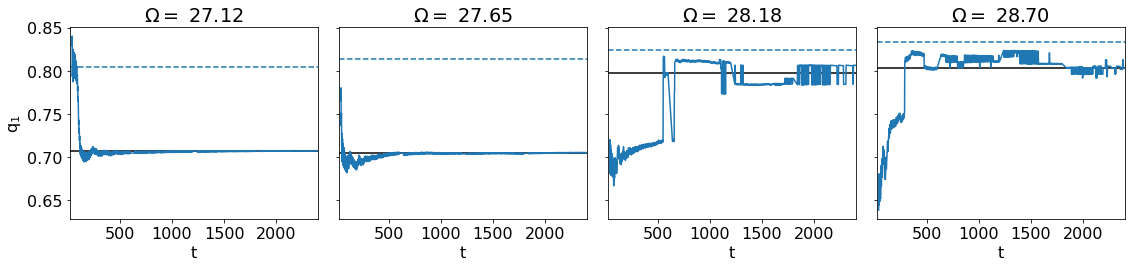

In [46]:
Da = 0.4
Omega_list = 3.5*np.arange(7.75, 8.3, 0.15)
pred_q_lsa_list = [q_max_lsa(Omega, Da, stress='sat') for Omega in Omega_list]

with open("q1_front_sims_sat_stress_t0-600.txt", "rb") as f:
    t_1, q1_1 = pickle.load(f)
with open("q1_front_sims_sat_stress_t600-1200.txt", "rb") as f:
    t_2, q1_2 = pickle.load(f)
with open("q1_front_sims_sat_stress_t1200-1800.txt", "rb") as f:
    t_3, q1_3 = pickle.load(f)
with open("q1_front_sims_sat_stress_t1800-2400.txt", "rb") as f:
    t_4, q1_4 = pickle.load(f)

fig, ax = plt.subplots(nrows=1, ncols=len(Omega_list), figsize=(4*len(Omega_list), 4), sharey = True)

last = len(Omega_list) - 1
q1_late_times = []
q1_late_times_std = []

for i, (Omega, pred_q_lsa) in enumerate(zip(Omega_list, pred_q_lsa_list)):
    t = np.array(t_1[i] + t_2[i] + t_3[i] + t_4[i])
    q1 = np.array(q1_1[i] + q1_2[i] + q1_3[i] + q1_4[i])
    ax[i].set_xlim(20, 2400)
    ax[i].axhline(pred_q_lsa, ls = '--', label = 'lsa' if i == last else None)
    q1_late_times.append(np.mean(q1[2*int(len(q1)/3):]))
    q1_late_times_std.append(np.std(q1[2*int(len(q1)/3):]))
    ax[i].axhline(np.mean(q1[int(2*len(q1)/3):]), c = 'k')
    ax[i].plot(t, q1)
    ax[i].set_title(r"$\Omega = $ {:.2f}".format(Omega))
    ax[i].set_xlabel('t')

ax[0].set_ylabel(r'$q_1$')
fig.set_tight_layout(True)
fig.savefig('Plots/q1_vs_t_front_sat.pdf')

$\zeta_c \propto c^2$

In [ ]:
get_q1_vs_t(0, 600, 2100, stress = 'c2', Omega_list = 0.5*np.arange(6.7, 7.4, 0.15), fname = "q1_front_sims_c2_stress_t")
get_q1_vs_t(600, 1200, 4200, stress = 'c2', Omega_list = 0.5*np.arange(6.7, 7.4, 0.15), fname = "q1_front_sims_c2_stress_t")
get_q1_vs_t(1200, 1800, 6300, stress = 'c2', Omega_list = 0.5*np.arange(6.7, 7.4, 0.15), fname = "q1_front_sims_c2_stress_t")
get_q1_vs_t(1800, 2400, 8400, stress = 'c2', Omega_list = 0.5*np.arange(6.7, 7.4, 0.15), fname = "q1_front_sims_c2_stress_t")

file found, loading...


<ipython-input-42-3cd229dfe42e>:51: RuntimeWarning: divide by zero encountered in true_divide
  wl = 1/freq


file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...
file found, loading...


In [ ]:
Da = 0.4
Omega_list = 0.5*np.arange(6.7, 7.4, 0.15)
pred_q_lsa_list = [q_max_lsa(Omega, Da, stress='c2') for Omega in Omega_list]

with open("q1_front_sims_c2_stress_t0-600.txt", "rb") as f:
    t_1, q1_1 = pickle.load(f)
with open("q1_front_sims_c2_stress_t600-1200.txt", "rb") as f:
    t_2, q1_2 = pickle.load(f)
with open("q1_front_sims_c2_stress_t1200-1800.txt", "rb") as f:
    t_3, q1_3 = pickle.load(f)
with open("q1_front_sims_c2_stress_t1800-2400.txt", "rb") as f:
    t_4, q1_4 = pickle.load(f)

fig, ax = plt.subplots(nrows=1, ncols=len(Omega_list), figsize=(4*len(Omega_list), 4), sharey = True)

last = len(Omega_list) - 1
q1_late_times = []
q1_late_times_std = []

for i, (Omega, pred_q_lsa) in enumerate(zip(Omega_list, pred_q_lsa_list)):
    t = np.array(t_1[i] + t_2[i] + t_3[i] + t_4[i])
    q1 = np.array(q1_1[i] + q1_2[i] + q1_3[i] + q1_4[i])
    ax[i].set_xlim(20, 2400)
    ax[i].set_ylim(0.7, 0.9)
    ax[i].axhline(pred_q_lsa, ls = '--', label = 'lsa' if i == last else None)
    q1_late_times.append(np.mean(q1[2*int(len(q1)/3):]))
    q1_late_times_std.append(np.std(q1[2*int(len(q1)/3):]))
    ax[i].axhline(np.mean(q1[int(2*len(q1)/3):]), c = 'k')
    ax[i].plot(t, q1)
    ax[i].set_title(r"$\Omega = $ {:.2f}".format(Omega))
    ax[i].set_xlabel('t')
ax[0].set_ylabel(r'$q_1$')
fig.set_tight_layout(True)
fig.savefig('Plots/q1_vs_t_front_c2.pdf')

#### 3. Compute lag of pattern behind front

========================== Compute distance from front to first peak of instability vs time ===============================

In [ ]:
Da_list = [0.2, 0.4, 0.8]
Omega_lists = [np.arange(10.5, 14, 0.25), np.arange(6.85, 10, 0.15), np.arange(4.5, 8, 0.25)]
tmax_list = [100, 150, 200]

stress = "lin"
init = "step"
bc = "fixed"

dx = 0.05
dt = 0.05
xmax = 500
tmax = 150 
x_save_interval = 1
t_save_interval = 10

plot_c = False

for (Da, Omega_list, tmax) in zip(Da_list, Omega_lists, tmax_list):

    fig, ax = plt.subplots()
    colormap = cm.get_cmap('viridis')
    colors = [colormap(x) for x in np.linspace(0, 1, len(Omega_list))]
    k_min_group_v = []

    for Omega, c in zip(Omega_list, colors):
        #load simulation   
        my_sim = Unique_Simulation(Da, Omega, stress, init, bc, dt, tmax, t_save_interval, dx, xmax, x_save_interval)
        #find peaks
        all_peaks = [signal.find_peaks(my_sim.sol_c[i], height = 1.0001)[0] for i in range(20, len(my_sim.sol_c))]
        #rightmost peak is at the front, second rightmost peak is the rightmost peak of instability
        front_peaks = [peaks[-1] for peaks in all_peaks]
        right_instab_peaks = [peaks[-2] for peaks in all_peaks]
        if plot_c:
            fig2, ax2 = plt.subplots(figsize = (6, 4))
            ind = np.where(my_sim.t > (3*tmax/4))[0][0]
            print(ind)
            my_sim.plot_c(my_sim.t[ind], ax = ax2)
            ax2.axvline(x = right_instab_peaks[ind - 20]* dx * x_save_interval, c = 'k', ls = '--')
            ax2.axvline(x = front_peaks[ind - 20]* dx * x_save_interval, c = 'k', ls = '--')
            fig2.set_tight_layout(True)
            fig2.savefig('Plots/c_with_peak_lines.pdf'.format(Omega))

        #plot distance from front as a function of time
        distance_from_front = (np.array(front_peaks) - np.array(right_instab_peaks)) * dx * x_save_interval
        imin = 20
        ax.plot(my_sim.t[imin:], distance_from_front, c = c, label = '{:.2f}'.format(Omega))
        iminfit = 80
        #fit to get speed
        z, pcov = curve_fit(line, my_sim.t[imin + iminfit:],  distance_from_front[iminfit:])
        k_min_group_v.append(z[0])
        ax.plot(my_sim.t[imin:], line(my_sim.t[imin:], *z), c = 'k', ls = '--')

    with open("k_minus_group_velocity_Da{:.2f}.txt".format(Da), "wb") as f: 
        pickle.dump(k_min_group_v, f)

    ax.set_xlabel("t")
    ax.set_ylabel("distance from front to first peak of instability")
    ax.set_title("Da = " + str(Da))
    ax.legend(loc = 3, bbox_to_anchor=(1, 0), ncol = 3)

In [ ]:
omega_lists = [np.arange(10.5, 14, 0.25), np.arange(6.85, 10.01, 0.15),np.arange(4.5, 8, 0.25)]
    
colormap = cm.get_cmap('Greys')
colors = [colormap(x) for x in np.linspace(1, 0.5, 3)]

fig, ax = plt.subplots(figsize = (6, 4.5))

for (Da, omega_list, c) in zip([.2, .4, .8], omega_lists, colors):
    
    with open("k_minus_group_velocity_Da{:.2f}.txt".format(Da), "rb") as f: 
        kmgv = pickle.load(f)
        
    k0 = 2/np.sqrt(Da)
    omega_c_star = omega_list[np.where(np.array(kmgv)<1e-2)[0][0]]
    
    ax.scatter(omega_list, np.array(kmgv)/k0, color = c, marker = 'o', s = 100, label = Da)
    ax.axhline(0, c = 'k', ls = '--')
    ax.axvline(omega_crit_inf(Da), c = c, ls = '--')
    ax.axvline(omega_c_star, c = c, ls = ':')
    
ax.text(x=6.45, y=0.9, s=r'$\Omega_c^* - \Omega_c$')
ax.set_xlabel(r"$\Omega$")
ax.set_ylabel(r"$(k^* - v_g)/k_0$")
ax.legend()
fig.tight_layout()
plt.savefig('Plots/k_min_group_velocity_mult_Da.pdf')